In [1]:
import sys
sys.path.insert(0, '/users/ankushroy/iris/src')
print(sys.path)

['/users/ankushroy/iris/src', '/users/ankushroy/iris_1/src/models/tokenizer', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python38.zip', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8/lib-dynload', '', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8/site-packages']


In [2]:
"""
Credits to https://github.com/CompVis/taming-transformers
"""

from dataclasses import dataclass
from typing import Any, Tuple


from einops import rearrange
import torch
import torch.nn as nn

#from dataset import Batch
from lpips import LPIPS
from nets import Encoder, Decoder
from utils import LossWithIntermediateLosses


#batch=2
@dataclass
class TokenizerEncoderOutput:
    z: torch.FloatTensor
    z_quantized: torch.FloatTensor
    tokens: torch.LongTensor


class Tokenizer(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, encoder: Encoder, decoder: Decoder, with_lpips: bool) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.encoder = encoder
        self.pre_quant_conv = torch.nn.Conv2d(encoder.config.z_channels, embed_dim, 1)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, decoder.config.z_channels, 1)
        self.decoder = decoder
        self.embedding.weight.data.uniform_(-1.0 / vocab_size, 1.0 / vocab_size)
        self.lpips = LPIPS().eval() if with_lpips else None

    def __repr__(self) -> str:
        return "tokenizer"

    def forward(self, x: torch.Tensor, should_preprocess: bool = False, should_postprocess: bool = False) -> Tuple[torch.Tensor]:
        outputs = self.encode(x, should_preprocess)
        decoder_input = outputs.z + (outputs.z_quantized - outputs.z).detach()
        reconstructions = self.decode(decoder_input, should_postprocess)
        return outputs.z, outputs.z_quantized, reconstructions

    def compute_loss(self, x, **kwargs: Any) -> LossWithIntermediateLosses:
        assert self.lpips is not None
        observations = self.preprocess_input(rearrange(x, 'b t c h w -> (b t) c h w'))
        z, z_quantized, reconstructions = self(observations, should_preprocess=False, should_postprocess=False)

        # Codebook loss. Notes:
        # - beta position is different from taming and identical to original VQVAE paper
        # - VQVAE uses 0.25 by default
        beta = 1.0
        commitment_loss = (z.detach() - z_quantized).pow(2).mean() + beta * (z - z_quantized.detach()).pow(2).mean()

        reconstruction_loss = torch.abs(observations - reconstructions).mean()
        perceptual_loss = torch.mean(self.lpips(observations, reconstructions))

        return LossWithIntermediateLosses(commitment_loss=commitment_loss, reconstruction_loss=reconstruction_loss,perceptual_loss=perceptual_loss)

    def encode(self, x: torch.Tensor, should_preprocess: bool = False) -> TokenizerEncoderOutput:
        if should_preprocess:
            x = self.preprocess_input(x)
        #print("Shape of x:", x.shape)
        shape = x.shape  # (..., C, H, W)
        x = x.view(-1, *shape[-3:])
        #print("Shape of x as (x_view):", x.shape)
        z = self.encoder(x)
        #print("Shape of z:",z.shape)
        z = self.pre_quant_conv(z)
        b, e, h, w = z.shape
        z_flattened = rearrange(z, 'b e h w -> (b h w) e')
        #print("Shape of z_flattend:",z_flattened.shape)
        dist_to_embeddings = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1) - 2 * torch.matmul(z_flattened, self.embedding.weight.t())

        tokens = dist_to_embeddings.argmin(dim=-1)
        #print("Shape of tokens:",tokens.shape)
        z_q = rearrange(self.embedding(tokens), '(b h w) e -> b e h w', b=b, e=e, h=h, w=w).contiguous()
        #print("Shape of z_q:",z_q.shape)
        # Reshape to original
        z = z.reshape(*shape[:-3], *z.shape[1:])
        #print("Shape of z:", z.shape)
        z_q = z_q.reshape(*shape[:-3], *z_q.shape[1:])
        #print("Shape of reshaped z_q:", z_q.shape)
        tokens = tokens.reshape(*shape[:-3], -1)
        #print("Shape of tokens:", tokens.shape)

        return TokenizerEncoderOutput(z, z_q, tokens)

    def decode(self, z_q: torch.Tensor, should_postprocess: bool = False) -> torch.Tensor:
        shape = z_q.shape  # (..., E, h, w)
        z_q = z_q.view(-1, *shape[-3:])
        z_q = self.post_quant_conv(z_q)
        rec = self.decoder(z_q)
        rec = rec.reshape(*shape[:-3], *rec.shape[1:])
        if should_postprocess:
            rec = self.postprocess_output(rec)
        return rec

    @torch.no_grad()
    def encode_decode(self, x: torch.Tensor, should_preprocess: bool = False, should_postprocess: bool = False) -> torch.Tensor:
        z_q = self.encode(x, should_preprocess).z_quantized
        return self.decode(z_q, should_postprocess)

    def preprocess_input(self, x: torch.Tensor) -> torch.Tensor:
        """x is supposed to be channels first and in [0, 1]"""
        return x.mul(2).sub(1)

    def postprocess_output(self, y: torch.Tensor) -> torch.Tensor:
        """y is supposed to be channels first and in [-1, 1]"""
        return y.add(1).div(2)

Pysteps configuration file found at: /users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8/site-packages/pysteps/pystepsrc



In [3]:
from typing import List

import torch
import torch.nn as nn
## Configuration files 
@dataclass
class EncoderDecoderConfig:
    resolution: int
    in_channels: int
    z_channels: int
    ch: int
    ch_mult: List[int]
    num_res_blocks: int
    attn_resolutions: List[int]
    out_ch: int
    dropout: float

In [ ]:
encoder = Encoder(EncoderDecoderConfig(resolution=128,
                                       in_channels=1,
                                        z_channels=512,
                                        ch=128,
                                        ch_mult= [1, 1, 1, 2, 2, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [4],
                                        out_ch= 1,
                                        dropout= 0.0))
decoder=Decoder(EncoderDecoderConfig(resolution=128,
                                       in_channels=1,
                                        z_channels=512,
                                        ch=128,
                                        ch_mult= [1, 1, 1, 2, 2, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [4],  
                                        out_ch= 1,
                                        dropout= 0.0))
vocab_size = 1024 # actual vocabulary size 
embed_dim = 512  # the desired embedding dimension of the codebook (coebook dim)
tokenizer = Tokenizer(vocab_size, embed_dim, encoder, decoder, with_lpips=True)
#print(encoder)
print(decoder)

For latent space [256,8,8] with codebook [1024,256]

In [4]:
encoder = Encoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=256,
                                        ch=128,
                                        ch_mult= [1, 1, 2, 2, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [16],
                                        out_ch= 1,
                                        dropout= 0.0))
decoder=Decoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=256,
                                        ch=128,
                                        ch_mult= [1, 1, 2, 2, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [16],
                                        out_ch= 1,
                                        dropout= 0.0))
vocab_size = 1024 # actual vocabulary size 
embed_dim = 256  # the desired embedding dimension of the codebook (coebook dim)
tokenizer = Tokenizer(vocab_size, embed_dim, encoder, decoder, with_lpips=True)
#print(encoder)
#print(decoder)

Tokenizer : shape of latent is (256, 16, 16).


For (1024 x 8 x 8)

In [8]:
encoder = Encoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=1024,
                                        ch=128,
                                        ch_mult= [1, 1, 1, 2, 2, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [8],
                                        out_ch= 1,
                                        dropout= 0.0))
decoder=Decoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=1024,
                                        ch=128,
                                        ch_mult= [1, 1, 1, 2, 2, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [8],  
                                        out_ch= 1,
                                        dropout= 0.0))
vocab_size = 1024 # actual vocabulary size 
embed_dim = 1024  # the desired embedding dimension of the codebook (coebook dim)
tokenizer = Tokenizer(vocab_size, embed_dim, encoder, decoder, with_lpips=True)
#print(encoder)
tokenizer.decoder.conv_out

Tokenizer : shape of latent is (1024, 8, 8).


Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [15]:
learning_rate=0.0001 # cfg training file 
optimizer_tokenizer = torch.optim.Adam(tokenizer.parameters(), lr=learning_rate)

In [5]:
# Define dataset
import torch
import sys
from nuwa_pytorch import VQGanVAE
import h5py
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.ndimage import zoom
def eventGeneration(start_time, obs_time = 3 ,lead_time = 6, time_interval = 30):
    # Generate event based on starting time point, return a list: [[t-4,...,t-1,t], [t+1,...,t+72]]
    # Get the start year, month, day, hour, minute
    year = int(start_time[0:4])
    month = int(start_time[4:6])
    day = int(start_time[6:8])
    hour = int(start_time[8:10])
    minute = int(start_time[10:12])
    #print(datetime(year=year, month=month, day=day, hour=hour, minute=minute))
    times = [(datetime(year, month, day, hour, minute) + timedelta(minutes=time_interval * (x+1))) for x in range(lead_time)]
    lead = [dt.strftime('%Y%m%d%H%M') for dt in times]
    times = [(datetime(year, month, day, hour, minute) - timedelta(minutes=time_interval * x)) for x in range(obs_time)]
    obs = [dt.strftime('%Y%m%d%H%M') for dt in times]
    obs.reverse()
    return lead, obs

from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from torchvision.transforms import ToTensor, Compose, CenterCrop
class radarDataset(Dataset):
    def __init__(self, root_dir, event_times, obs_number = 3, pred_number = 6, transform=None):
        # event_times is an array of starting time t(string)
        # transform is the preprocessing functions
        self.root_dir = root_dir
        self.transform = transform
        self.event_times = event_times
        self.obs_number = obs_number
        self.pred_number = pred_number
    def __len__(self):
        return len(self.event_times)
    def __getitem__(self, idx):
        start_time = str(self.event_times[idx])
        time_list_pre, time_list_obs = eventGeneration(start_time, self.obs_number, self.pred_number)
        output = []
        time_list = time_list_obs + time_list_pre
        #print(time_list)
        for time in time_list:
            year = time[0:4]
            month = time[4:6]
            #path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAC_MFBS_EM_5min_' + time + '_NL.h5'
            path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAP_5min_' + time + '.h5'
            image = np.array(h5py.File(path)['image1']['image_data'])
            #image = np.ma.masked_where(image == 65535, image)
            image = image[264:520,242:498]
            
            image[image == 65535] = 0
            image = image.astype('float32')
            image = image/100*12
            image = np.clip(image, 0, 128)
            image = image/40
            #image = 2*image-1 #normalize to [-1,1]
            output.append(image)
            #print(image)
        output = torch.permute(torch.tensor(np.array(output)), (1, 2, 0))
        output = self.transform(np.array(output))
        return output
#root_dir = '/users/hbi/data/RAD_NL25_RAC_MFBS_EM_5min/'
#dataset = radarDataset(root_dir, ["200808031600"], transform = Compose([ToTensor(),CenterCrop(256)]))
#print(image.shape)

In [7]:
# develop dataset
from torch.cuda.amp import autocast
#from torch.autograd import Variable
import pandas as pd
root_dir = '/home/hbi/RAD_NL25_RAP_5min/' 
batch_size=1

df_train = pd.read_csv('/users/ankushroy/taming-transformers/training_Delfland08-14_20.csv', header = None)
event_times = df_train[0].to_list()
dataset_train = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_s = pd.read_csv('/users/ankushroy/taming-transformers/training_Delfland08-14.csv', header = None)
event_times = df_train_s[0].to_list()
dataset_train_del = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_test = pd.read_csv('/users/ankushroy/taming-transformers/testing_Delfland18-20.csv', header = None)
event_times = df_test[0].to_list()
dataset_test = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_vali = pd.read_csv('/users/ankushroy/taming-transformers/validation_Delfland15-17.csv', header = None)
event_times = df_vali[0].to_list()
dataset_vali = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_train_aa = pd.read_csv('/users/ankushroy/taming-transformers/training_Aa08-14.csv', header = None)
event_times = df_train_aa[0].to_list()
dataset_train_aa = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_dw = pd.read_csv('/users/ankushroy/taming-transformers/training_Dwar08-14.csv', header = None)
event_times = df_train_dw[0].to_list()
dataset_train_dw = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))    

df_train_re = pd.read_csv('/users/ankushroy/taming-transformers/training_Regge08-14.csv', header = None)
event_times = df_train_re[0].to_list()
dataset_train_re = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))   

data_list = [dataset_train_aa, dataset_train_dw, dataset_train_del, dataset_train_re]
train_aadedwre = torch.utils.data.ConcatDataset(data_list)

print(len(train_aadedwre), len(dataset_test), len(dataset_vali))
loaders = { 'train' :DataLoader(train_aadedwre, batch_size, shuffle=True, num_workers=8),
            'test' :DataLoader(dataset_test, batch_size, shuffle=False, num_workers=8), 
           'valid' :DataLoader(dataset_vali, batch_size, shuffle=False, num_workers=8),
          
          'train_aa5' :DataLoader(dataset_train_aa, batch_size, shuffle=False, num_workers=8),
          'train_dw5' :DataLoader(dataset_train_dw, batch_size, shuffle=False, num_workers=8),
          'train_del5' :DataLoader(dataset_train_del, batch_size, shuffle=True, num_workers=8),
          'train_re5' :DataLoader(dataset_train_re, batch_size, shuffle=False, num_workers=8),
          }


30632 3493 3560


Displaying images from train DataLoader
torch.Size([4, 9, 256, 256])


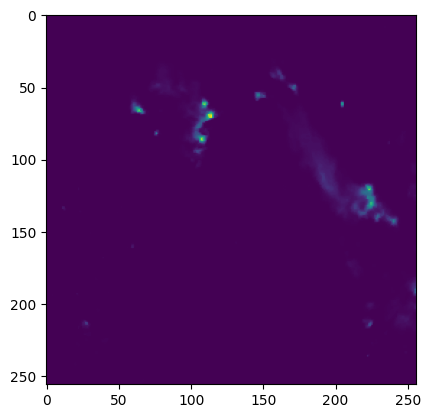

Displaying images from test DataLoader
torch.Size([4, 9, 256, 256])


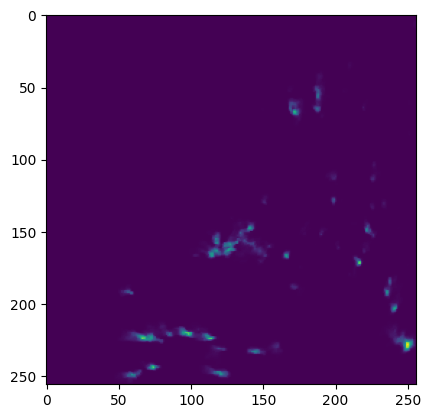

Displaying images from valid DataLoader
torch.Size([4, 9, 256, 256])


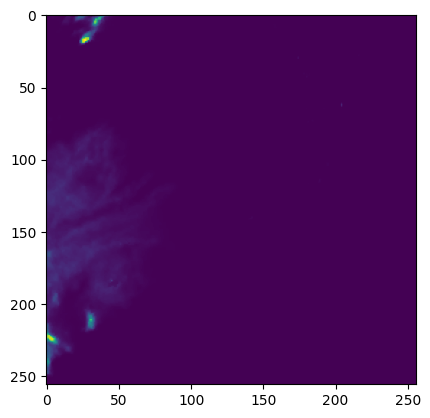

Displaying images from train_aa5 DataLoader
torch.Size([4, 9, 256, 256])


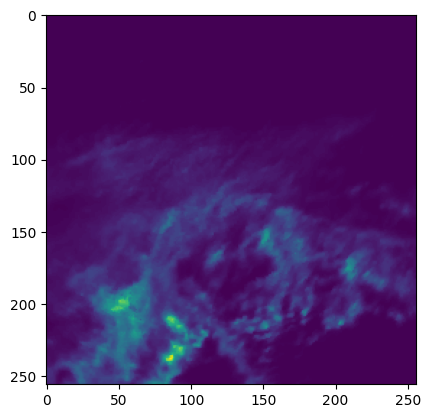

Displaying images from train_dw5 DataLoader
torch.Size([4, 9, 256, 256])


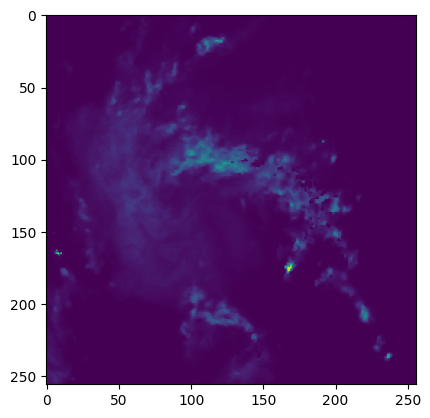

Displaying images from train_del5 DataLoader
torch.Size([4, 9, 256, 256])


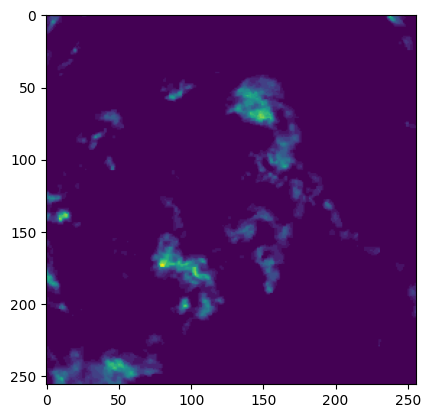

Displaying images from train_re5 DataLoader
torch.Size([4, 9, 256, 256])


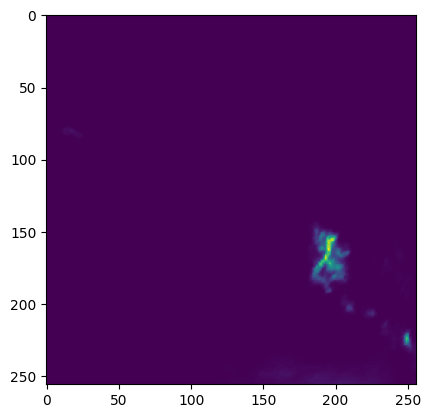

In [13]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img.numpy().squeeze()
    plt.imshow(img)
    plt.show()

# Display one image from each DataLoader
for name, loader in loaders.items():
    dataiter = iter(loader)
    images = dataiter.next()
    print(f"Displaying images from {name} DataLoader")
    print(images.shape)
    imshow(images[0][0])  # Display the first channel of the first image in the batch

In [8]:
# Initializing Device as cuda:0
cuda_version = torch.version.cuda
print("CUDA version:", cuda_version)
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("PyTorch version:", torch.__version__)

CUDA version: 11.3
True
cuda:0
PyTorch version: 1.11.0


Visulaizing the 128 x 128 images

torch.Size([1, 9, 128, 128])
torch.Size([9, 128, 128])


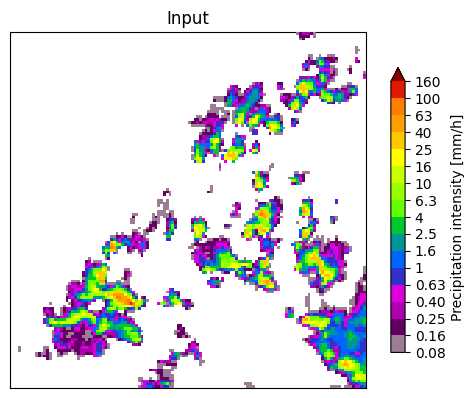

torch.Size([1, 9, 128, 128])
torch.Size([9, 128, 128])


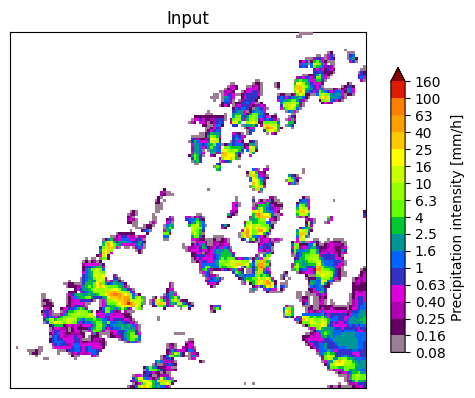

torch.Size([1, 9, 128, 128])
torch.Size([9, 128, 128])


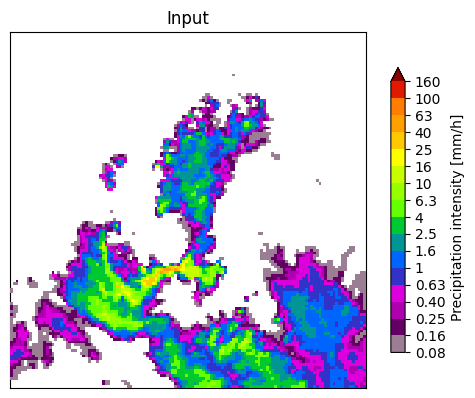

torch.Size([1, 9, 128, 128])
torch.Size([9, 128, 128])


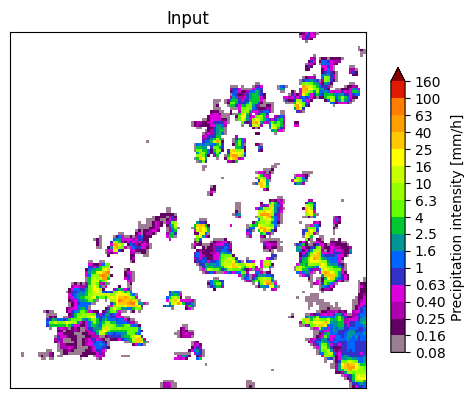

torch.Size([1, 9, 128, 128])
torch.Size([9, 128, 128])


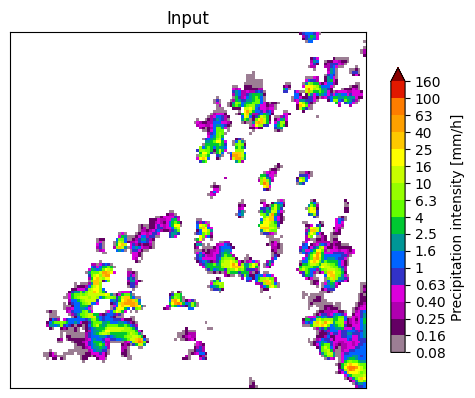

In [22]:
from pysteps.visualization import plot_precip_field
device = 'cuda:0'
for i, images in enumerate(loaders['test']):
    if i<0:continue
    if i>=5:break
    image = images[0]
    print(images.shape)
    print(image.shape)
    image = image.unsqueeze(1)
    image = image[3:4,:, :, :] # [9,128,128] --> [9,1,128,128]
    input_image= image.to(device)
    
    for t in range(1):
        a_r_display = input_image[t,0,:,:].to('cpu').detach().numpy()*40
        plt.figure(figsize=(16, 4))
        plt.subplot(131)
        plot_precip_field(a_r_display, title="Input")
        plt.tight_layout()
        plt.show()

In [18]:
##Training loop VQVAE 
import numpy as np
from collections import defaultdict
loss_total=0.0
intermediate_losses = defaultdict(float)
num_epochs=2
device = torch.device("cuda:0")  # Specify the GPU device
tokenizer.to(device)
tokenizer.train()
all_metrics = []  # List to store metrics for all epochs

for epoch in range(num_epochs):
    #save_epoch = epoch in [2]
    loss_total_epoch=0.0
    optimizer_tokenizer.zero_grad()
    intermediate_losses = {}
    print("epoch {}".format(epoch))
    for i, images in enumerate(loaders['train']):
        image = images.unsqueeze(2)
        image =  image.to(device)
        losses=tokenizer.compute_loss(image)
        loss_total += losses.loss_total
        print("Losses: Total = {:.4f}".format(losses.loss_total.item())) 
        for loss_name, loss_value in losses.intermediate_losses.items():
            if i == 0:
                intermediate_losses[f'Tokenizer/train/{loss_name}'] = loss_value
            else:
                intermediate_losses[f'Tokenizer/train/{loss_name}'] += loss_value
  
    
    loss_total = loss_total/i
    optimizer_tokenizer.zero_grad()
    loss_total.backward()
    optimizer_tokenizer.step()
        
   
        
    metrics = {f'Tokenizer/train/total_loss': loss_total, **intermediate_losses}
    print("Epoch {}: Total Loss = {:.4f}".format(epoch, metrics[f'Tokenizer/train/total_loss']))

    if epoch%1==0:
        torch.save({
        'model_state_dict': tokenizer.state_dict(),
        'optimizer_state_dict': optimizer_tokenizer.state_dict(),
        }, '/space/ankushroy/Tokeniser_exp2_1024_embdim_16/vqvae_checkpoint_epoch{}'.format(epoch+1))

    all_metrics.append(metrics)  # Save metrics for the current epoch to the list


# Convert the metrics list to a NumPy array
metrics_array = np.array(all_metrics)

# Save the metrics array as a NumPy file
np.save('/space/ankushroy/Tokeniser_exp2_1024_embdim_16/metrices.npy', metrics_array)
# Print all errors from each epoch's metrics dictionary
# print(all_metrics)


epoch 0
Losses: Total = 1.4873
Losses: Total = 1.4868


RuntimeError: CUDA out of memory. Tried to allocate 18.00 MiB (GPU 0; 47.54 GiB total capacity; 45.71 GiB already allocated; 15.25 MiB free; 45.73 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [9]:
##Training loop VQVAE 
import numpy as np
from collections import defaultdict
loss_total_step=0.0
intermediate_losses = defaultdict(float)
num_epochs=150
device = torch.device("cuda:0")  # Specify the GPU device
epoch_start=0
tokenizer.to(device)
all_metrics = []  # List to store metrics for all epochs

for epoch in range(epoch_start,num_epochs):
    save_epoch = epoch in [0,4,9,19,29,39,49,59,69,79,89,99,109,119,129,139,149]
    #save_epoch = epoch in [2]
    loss_total_epoch=0.0
    #optimizer_tokenizer.zero_grad()
    intermediate_losses = {}
    print("epoch {}".format(epoch))
    for i, images in enumerate(loaders['train']):
        loss_total_step=0.0
        image = images[0]
        image = image.unsqueeze(1)
        image = image[3:4, :, :, :]
        input_image= image.to(device)  # batch x
        #print(input_image.size())
        encoder_output = tokenizer.encode(input_image) #Both the lines one complete forward pass
        losses=tokenizer.compute_loss(input_image)
        
        loss_total_step += losses.loss_total 
        loss_total_epoch += loss_total_step.item()/64
        if (i+1) % 64 == 0:
            (loss_total_step/64).backward()
            optimizer_tokenizer.step()
            optimizer_tokenizer.zero_grad()
            
            print("Losses: Total = {:.4f}".format(loss_total_step.item()))
            #loss_total_step=0.0
        

        for loss_name, loss_value in losses.intermediate_losses.items():
                intermediate_losses[f"{str(tokenizer)}/train/{loss_name}"] = loss_value/64
    
        
    metrics = {f'{str(Tokenizer)}/train/total_loss': loss_total_epoch, **intermediate_losses}
    print("Epoch {}: Total Loss = {:.4f}".format(epoch, metrics[f'{str(Tokenizer)}/train/total_loss']))

    if save_epoch:
        torch.save({
        'model_state_dict': tokenizer.state_dict(),
        'optimizer_state_dict': optimizer_tokenizer.state_dict(),
        }, '/space/ankushroy/Tokeniser_exp2_512_embdim_16/vqvae_checkpoint_epoch{}'.format(epoch+1))

    all_metrics.append(metrics)  # Save metrics for the current epoch to the list


# Convert the metrics list to a NumPy array
metrics_array = np.array(all_metrics)

# Save the metrics array as a NumPy file
np.save('/space/ankushroy/Tokeniser_exp2_512_embdim_16/metrices.npy', metrics_array)
# Print all errors from each epoch's metrics dictionary
# print(all_metrics)

epoch 0


EinopsError:  Error while processing rearrange-reduction pattern "b t c h w -> (b t) c h w".
 Input tensor shape: torch.Size([1, 1, 256, 256]). Additional info: {}.
 Expected 5 dimensions, got 4

In [79]:
torch.cuda.empty_cache()
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
threshold = 0.0
device = 'cuda:0'
pcc_average = 0
tokenizer=tokenizer.to(device)
tokenizer.eval()

checkpoint = torch.load('/space/ankushroy/Tokeniser_exp2_1024_embdim_10/vqvae_checkpoint_epoch350', map_location=device)
tokenizer.load_state_dict(checkpoint['model_state_dict'])
optimizer_tokenizer.load_state_dict(checkpoint['optimizer_state_dict'])

for i, images in enumerate(loaders['test']):
    if i>batch_size:break
    #image = images[0]
    print(images.shape)
    
    for j in range(images.shape[0]):
        for k in range(images.shape[1]):
            image = images[j,k,:,:].unsqueeze(0).unsqueeze(1)
            print(image.shape)
        #image = image[4:5,:,:,:] #taking one image out of the 9 sequence images
        #input_image = image.to(device)
        #output_image = tokenizer.encode_decode(input_image)
        #pyst_input = 
        
        #print('input',input_image.shape)
        #print('output',output_image.shape)

torch.Size([2, 9, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([2, 9, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1,

In [ ]:
from einops import rearrange
def compute_metrics (input_images, reconstruction):
    threshold = 0.0
    input_images = rearrange(input_images, 'b s h w -> (bs) h w')
    reconstruction = rearrange(reconstruction, 'b s h w -> (bs) h w')
    # input images and reconstruction/prediction images should be of the same shape to perform the above operation
    for i in range(input_images.shape[0]):
        a_display = input_images[i].to('cpu').detach().numpy()*40
        ar_display = reconstruction[i].to('cpu').detach().numpy()*40
        ar_display[ar_display < threshold] = 0.0
        
        scores_cat1 = det_cat_fct(ar_display, a_display, 1)
        scores_cat2 = det_cat_fct(ar_display, a_display, 2)
        scores_cat8 = det_cat_fct(ar_display, a_display, 8)
        scores_cont = det_cont_fct(ar_display, a_display, thr=0.1)
        
        scores_spatial = intensity_scale(ar_display, a_display, 'FSS', 0.1, [1,10,20,30])
        pcc_average += float(np.around(scores_cont['corr_p'],3))
        if True:
            print('MSE:', np.around(scores_cont['MSE'],3), 
                    'MAE:', np.around(scores_cont['MAE'],3), 
                    'PCC:', np.around(scores_cont['corr_p'],3),'\n', 
                    'CSI(1mm):', np.around(scores_cat1['CSI'],3), # CSI: TP/(TP+FP+FN)
                    'CSI(2mm):', np.around(scores_cat2['CSI'],3),
                    'CSI(8mm):', np.around(scores_cat8['CSI'],3),'\n',
                    'ACC(1mm):', np.around(scores_cat1['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
                    'ACC(2mm):', np.around(scores_cat2['ACC'],3),
                    'ACC(8mm):', np.around(scores_cat8['ACC'],3),'\n',
                    'FSS(1km):', np.around(scores_spatial[0][0],3),
                    'FSS(10km):', np.around(scores_spatial[1][0],3),
                    'FSS(20km):', np.around(scores_spatial[2][0],3),
                    'FSS(30km):', np.around(scores_spatial[3][0],3)
                    )  
            plt.figure(figsize=(16, 4))
            plt.subplot(131)
            plot_precip_field(a_display, title="Input")
            plt.subplot(132)
            plot_precip_field(ar_display, title="Reconstruction/Prediction")
            
            plt.tight_layout()
            plt.show()
    print('pcc_average:', pcc_average/i)
        
        

Contingency Table (contab):
{'thr': 1, 'axis': None, 'hits': array(3199), 'false_alarms': array(2511), 'misses': array(3049), 'correct_negatives': array(56777)}
Contingency Table (contab):
{'thr': 2, 'axis': None, 'hits': array(1820), 'false_alarms': array(1806), 'misses': array(2505), 'correct_negatives': array(59405)}
Contingency Table (contab):
{'thr': 8, 'axis': None, 'hits': array(432), 'false_alarms': array(538), 'misses': array(1323), 'correct_negatives': array(63243)}
MSE: 14.671 MAE: 0.82 PCC: 0.444 
 CSI(1mm): 0.365 CSI(2mm): 0.297 CSI(8mm): 0.188 
 ACC(1mm): 0.915 ACC(2mm): 0.934 ACC(8mm): 0.972 
 FSS(1km): 0.946 FSS(10km): 0.916 FSS(20km): 0.847 FSS(30km): 0.657


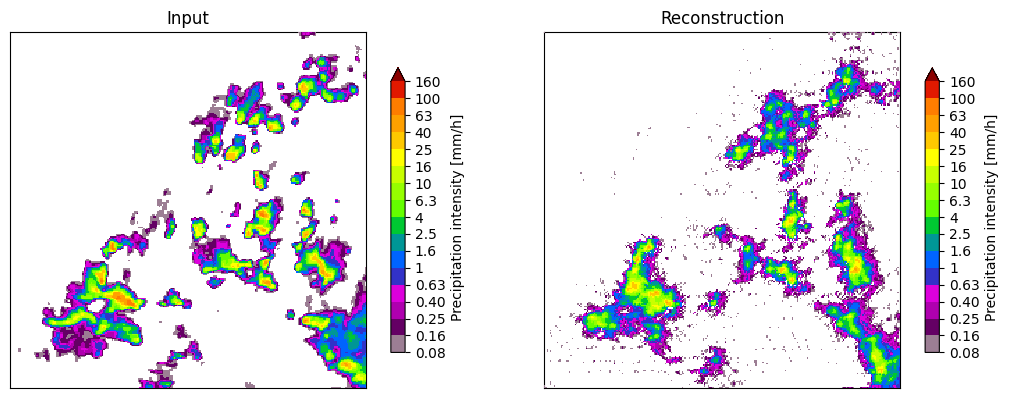

Contingency Table (contab):
{'thr': 1, 'axis': None, 'hits': array(3100), 'false_alarms': array(2301), 'misses': array(3678), 'correct_negatives': array(56457)}
Contingency Table (contab):
{'thr': 2, 'axis': None, 'hits': array(1688), 'false_alarms': array(1666), 'misses': array(2935), 'correct_negatives': array(59247)}
Contingency Table (contab):
{'thr': 8, 'axis': None, 'hits': array(387), 'false_alarms': array(514), 'misses': array(1415), 'correct_negatives': array(63220)}
MSE: 14.186 MAE: 0.825 PCC: 0.441 
 CSI(1mm): 0.341 CSI(2mm): 0.268 CSI(8mm): 0.167 
 ACC(1mm): 0.909 ACC(2mm): 0.93 ACC(8mm): 0.971 
 FSS(1km): 0.935 FSS(10km): 0.908 FSS(20km): 0.841 FSS(30km): 0.648


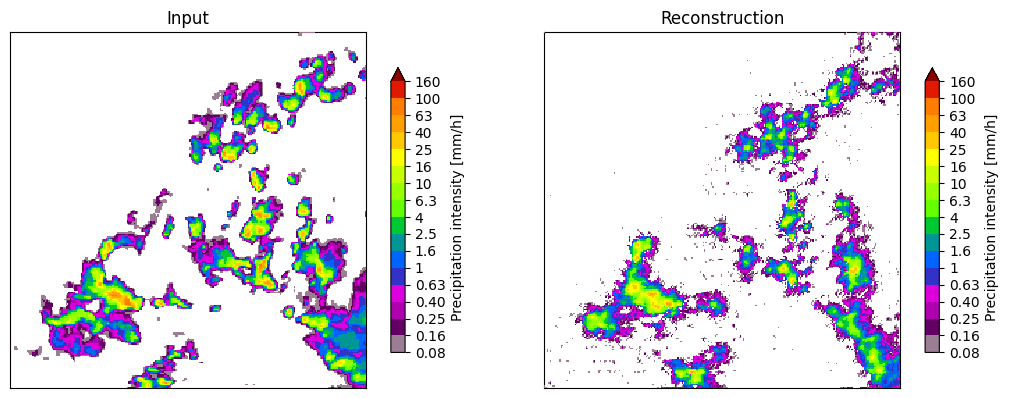

Contingency Table (contab):
{'thr': 1, 'axis': None, 'hits': array(6333), 'false_alarms': array(2050), 'misses': array(4442), 'correct_negatives': array(52711)}
Contingency Table (contab):
{'thr': 2, 'axis': None, 'hits': array(3491), 'false_alarms': array(1676), 'misses': array(2136), 'correct_negatives': array(58233)}
Contingency Table (contab):
{'thr': 8, 'axis': None, 'hits': array(268), 'false_alarms': array(563), 'misses': array(472), 'correct_negatives': array(64233)}
MSE: 3.322 MAE: 0.49 PCC: 0.601 
 CSI(1mm): 0.494 CSI(2mm): 0.478 CSI(8mm): 0.206 
 ACC(1mm): 0.901 ACC(2mm): 0.942 ACC(8mm): 0.984 
 FSS(1km): 0.938 FSS(10km): 0.921 FSS(20km): 0.888 FSS(30km): 0.795


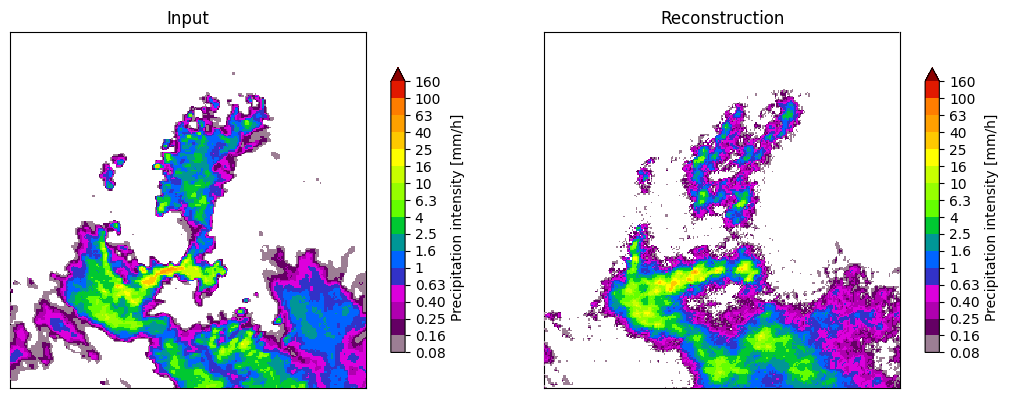

Contingency Table (contab):
{'thr': 1, 'axis': None, 'hits': array(2827), 'false_alarms': array(2254), 'misses': array(2977), 'correct_negatives': array(57478)}
Contingency Table (contab):
{'thr': 2, 'axis': None, 'hits': array(1630), 'false_alarms': array(1599), 'misses': array(2435), 'correct_negatives': array(59872)}
Contingency Table (contab):
{'thr': 8, 'axis': None, 'hits': array(275), 'false_alarms': array(506), 'misses': array(1483), 'correct_negatives': array(63272)}
MSE: 14.808 MAE: 0.813 PCC: 0.383 
 CSI(1mm): 0.351 CSI(2mm): 0.288 CSI(8mm): 0.121 
 ACC(1mm): 0.92 ACC(2mm): 0.938 ACC(8mm): 0.97 
 FSS(1km): 0.933 FSS(10km): 0.898 FSS(20km): 0.825 FSS(30km): 0.625


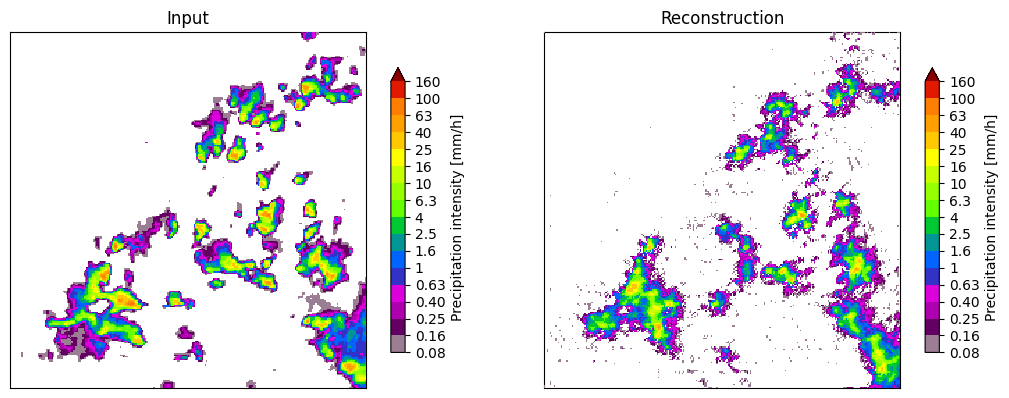

Contingency Table (contab):
{'thr': 1, 'axis': None, 'hits': array(2292), 'false_alarms': array(2375), 'misses': array(3238), 'correct_negatives': array(57631)}
Contingency Table (contab):
{'thr': 2, 'axis': None, 'hits': array(1331), 'false_alarms': array(1490), 'misses': array(2633), 'correct_negatives': array(60082)}
Contingency Table (contab):
{'thr': 8, 'axis': None, 'hits': array(262), 'false_alarms': array(463), 'misses': array(1435), 'correct_negatives': array(63376)}
MSE: 14.838 MAE: 0.792 PCC: 0.31 
 CSI(1mm): 0.29 CSI(2mm): 0.244 CSI(8mm): 0.121 
 ACC(1mm): 0.914 ACC(2mm): 0.937 ACC(8mm): 0.971 
 FSS(1km): 0.941 FSS(10km): 0.907 FSS(20km): 0.831 FSS(30km): 0.623


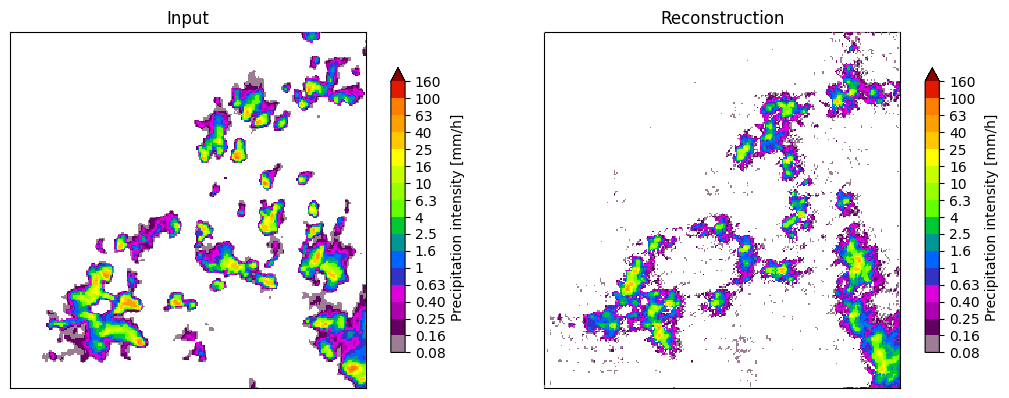

pcc_average: 0.43579999999999997


: 

In [8]:
torch.cuda.empty_cache()
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
threshold = 0.0
device = 'cuda:0'
pcc_average = 0
tokenizer=tokenizer.to(device)
tokenizer.eval()

for i, images in enumerate(loaders['test']):
    if i>=5:break

    
    checkpoint = torch.load('/space/ankushroy/Tokeniser_exp2_1024_embdim_10/vqvae_checkpoint_epoch350', map_location=device)
    tokenizer.load_state_dict(checkpoint['model_state_dict'])
    #optimizer_tokenizer.load_state_dict(checkpoint['optimizer_state_dict'])
    image = images[0]
    image = image.unsqueeze(1)
    image = image[3:4, :, :, :]
    input_image= image.to(device)  # batch x
        #print(input_image.size())
    a_r = tokenizer.encode_decode(input_image)
        #checkpoint = torch.load('/users/zboucher/iris/src/models/tokenizer/vqvae_epoch70', map_location = 'cpu')
        #vae.load_state_dict(checkpoint)
        #a_r2 = vae(a)

    for t in range(batch_size):
        a_display = input_image[t,0,:,:].to('cpu').detach().numpy()*40
        a_r_display = a_r[t,0,:,:].to('cpu').detach().numpy()*40
        
        a_r_display[a_r_display < threshold] = 0.0
        
        scores_cat1 = det_cat_fct(a_r_display, a_display, 1)
        scores_cat2 = det_cat_fct(a_r_display, a_display, 2)
        scores_cat8 = det_cat_fct(a_r_display, a_display, 8)
        scores_cont = det_cont_fct(a_r_display, a_display, thr=0.1)
        #contab = det_cat_fct_init(1)
        #fill_contab = det_cat_fct_accum(contab, a_r_display, a_display)
        scores_spatial = intensity_scale(a_r_display, a_display, 'FSS', 0.1, [1,10,20,30])
        pcc_average += float(np.around(scores_cont['corr_p'],3))
        if True:
            print('MSE:', np.around(scores_cont['MSE'],3), 
                    'MAE:', np.around(scores_cont['MAE'],3), 
                    'PCC:', np.around(scores_cont['corr_p'],3),'\n', 
                    'CSI(1mm):', np.around(scores_cat1['CSI'],3), # CSI: TP/(TP+FP+FN)
                    'CSI(2mm):', np.around(scores_cat2['CSI'],3),
                    'CSI(8mm):', np.around(scores_cat8['CSI'],3),'\n',
                    'ACC(1mm):', np.around(scores_cat1['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
                    'ACC(2mm):', np.around(scores_cat2['ACC'],3),
                    'ACC(8mm):', np.around(scores_cat8['ACC'],3),'\n',
                    'FSS(1km):', np.around(scores_spatial[0][0],3),
                    'FSS(10km):', np.around(scores_spatial[1][0],3),
                    'FSS(20km):', np.around(scores_spatial[2][0],3),
                    'FSS(30km):', np.around(scores_spatial[3][0],3),
                    
                )  
            plt.figure(figsize=(16, 4))
            plt.subplot(131)
            plot_precip_field(a_display, title="Input")
            plt.subplot(132)
            plot_precip_field(a_r_display, title="Reconstruction")
            
            plt.tight_layout()
            plt.show()
print('pcc_average:', pcc_average/i)

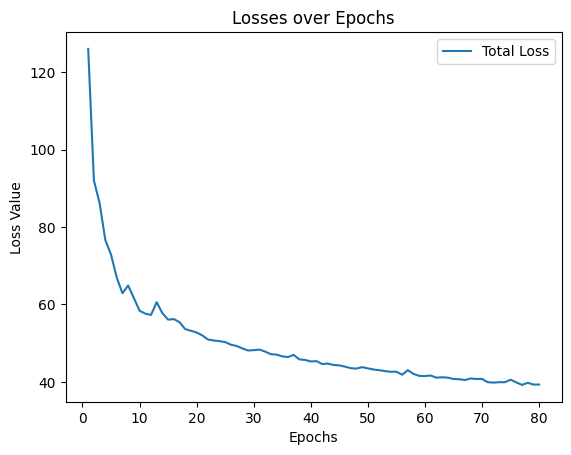

In [8]:
import numpy as np

# Load the NumPy array from file
array = np.load('/space/ankushroy/Tokeniser_Epochs_Chkpts_512/metrices.npy', allow_pickle=True)

import matplotlib.pyplot as plt

metrics = array  # List of 79 metrics dictionaries

# Create lists to store the loss values
total_losses = []
commitment_losses = []
reconstruction_losses = []
perceptual_losses = []

# Extract the loss values from each metrics dictionary
for metric in metrics:
    total_losses.append(metric["<class '__main__.Tokenizer'>/train/total_loss"])
    commitment_losses.append(metric["tokenizer/train/commitment_loss"])
    reconstruction_losses.append(metric["tokenizer/train/reconstruction_loss"])
    perceptual_losses.append(metric["tokenizer/train/perceptual_loss"])

# Plot the losses
epochs = range(1, len(metrics) + 1)

plt.plot(epochs, total_losses, label='Total Loss')
#plt.plot(epochs, commitment_losses, label='Commitment Loss')
#plt.plot(epochs, reconstruction_losses, label='Reconstruction Loss')
#plt.plot(epochs, perceptual_losses, label='Perceptual Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Losses over Epochs')
plt.legend()
plt.show()


In [ ]:
print(total_losses)

In [ ]:
#Training the Model from 40th checkpoint (to 120th epoch)
import numpy as np
from collections import defaultdict
device = torch.device("cuda:0")  # Specify the GPU device
tokenizer.to(device)
checkpoint_path = '/space/ankushroy/Tokeniser_exp2_1024_embdim_13/vqvae_checkpoint_epoch40'
checkpoint = torch.load(checkpoint_path,map_location=device)
tokenizer.load_state_dict(checkpoint['model_state_dict'])
optimizer_tokenizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_total_step=0.0
intermediate_losses = defaultdict(float)

tokenizer.train()
epoch_start=40
num_epochs=120

all_metrics = []  # List to store metrics for all epochs

for epoch in range(epoch_start,num_epochs):
    save_epoch = epoch in [44,49,59,69,79,89,99,109,119]
    
    loss_total_epoch=0.0
    optimizer_tokenizer.zero_grad()
    intermediate_losses = {}
    print("epoch {}".format(epoch))
    for i, images in enumerate(loaders['train']):
        loss_total_step=0.0
        image = images[0]
        image = image.unsqueeze(1)
        image = image[3:4, :, :, :]
        input_image= image.to(device)  # batch x
        #print(input_image.size())
        encoder_output = tokenizer.encode(input_image)
        losses=tokenizer.compute_loss(input_image)
        
        loss_total_step += losses.loss_total 
        loss_total_epoch += loss_total_step.item()/64
        if (i+1) % 64 == 0:
            (loss_total_step/64).backward()
            optimizer_tokenizer.step()
            optimizer_tokenizer.zero_grad()
            
            print("Losses: Total = {:.4f}".format(loss_total_step.item()))
            #loss_total_step=0.0
        

        for loss_name, loss_value in losses.intermediate_losses.items():
                intermediate_losses[f"{str(tokenizer)}/train/{loss_name}"] = loss_value/64
    
        
    metrics = {f'{str(Tokenizer)}/train/total_loss': loss_total_epoch, **intermediate_losses}
    print("Epoch {}: Total Loss = {:.4f}".format(epoch, metrics[f'{str(Tokenizer)}/train/total_loss']))

    if save_epoch:
        torch.save({
        'model_state_dict': tokenizer.state_dict(),
        'optimizer_state_dict': optimizer_tokenizer.state_dict(),
        }, '/space/ankushroy/Tokeniser_exp2_1024_embdim_13/vqvae_checkpoint_epoch{}'.format(epoch+1))

    all_metrics.append(metrics)  # Save metrics for the current epoch to the list


# Convert the metrics list to a NumPy array
metrics_array = np.array(all_metrics)

# Save the metrics array as a NumPy file
np.save('/space/ankushroy/Tokeniser_exp2_1024_embdim_13/metrices.npy', metrics_array)
# Print all errors from each epoch's metrics dictionary
# print(all_metrics)

epoch 40
Losses: Total = 0.1211
Losses: Total = 0.1364
Losses: Total = 0.1699
Losses: Total = 0.1363
Losses: Total = 0.1208
Losses: Total = 0.2366
Losses: Total = 0.2115
Losses: Total = 0.1005
Losses: Total = 0.0179
Losses: Total = 0.0385
Losses: Total = 0.1485
Losses: Total = 0.1568
Losses: Total = 0.2003
Losses: Total = 0.1689
Losses: Total = 0.1449
Losses: Total = 0.2006
Losses: Total = 0.1310
Losses: Total = 0.1591
Losses: Total = 0.0880
Losses: Total = 0.1312
Losses: Total = 0.1049
Losses: Total = 0.1853
Losses: Total = 0.1547
Losses: Total = 0.0925
Losses: Total = 0.1715
Losses: Total = 0.2590
Losses: Total = 0.1077
Losses: Total = 0.1751
Losses: Total = 0.1166
Losses: Total = 0.1171
Losses: Total = 0.0780
Losses: Total = 0.1430
Losses: Total = 0.1577
Losses: Total = 0.1895
Losses: Total = 0.0707
Losses: Total = 0.1035
Losses: Total = 0.0920
Losses: Total = 0.0507
Losses: Total = 0.0873
Losses: Total = 0.0759
Losses: Total = 0.0756
Losses: Total = 0.1671
Losses: Total = 0.1660
Lo

Losses: Total = 0.1039
Losses: Total = 0.2116
Losses: Total = 0.1128
Losses: Total = 0.2177
Losses: Total = 0.1114
Losses: Total = 0.1216
Losses: Total = 0.1154
Losses: Total = 0.1817
Losses: Total = 0.1528
Losses: Total = 0.0439
Losses: Total = 0.1262
Losses: Total = 0.0538
Losses: Total = 0.2910
Losses: Total = 0.1234
Losses: Total = 0.0475
Losses: Total = 0.2704
Losses: Total = 0.1309
Losses: Total = 0.0942
Losses: Total = 0.1504
Losses: Total = 0.1319
Losses: Total = 0.1647
Losses: Total = 0.1157
Losses: Total = 0.1736
Losses: Total = 0.0786
Losses: Total = 0.1205
Losses: Total = 0.1067
Losses: Total = 0.1141
Losses: Total = 0.0710
Losses: Total = 0.0904
Losses: Total = 0.1188
Losses: Total = 0.1166
Losses: Total = 0.1000
Losses: Total = 0.1222
Losses: Total = 0.1595
Losses: Total = 0.0773
Losses: Total = 0.1894
Losses: Total = 0.0639
Losses: Total = 0.1244
Losses: Total = 0.1353
Losses: Total = 0.1502
Losses: Total = 0.1750
Losses: Total = 0.0802
Losses: Total = 0.0487
Losses: Tot

Losses: Total = 0.1149
Losses: Total = 0.1161
Losses: Total = 0.1177
Losses: Total = 0.0751
Losses: Total = 0.1511
Losses: Total = 0.1837
Losses: Total = 0.1190
Losses: Total = 0.0752
Losses: Total = 0.0733
Losses: Total = 0.1681
Losses: Total = 0.0724
Losses: Total = 0.1738
Losses: Total = 0.1071
Losses: Total = 0.1387
Losses: Total = 0.2026
Losses: Total = 0.1613
Losses: Total = 0.1218
Losses: Total = 0.0464
Losses: Total = 0.2063
Losses: Total = 0.1525
Losses: Total = 0.1208
Losses: Total = 0.0717
Losses: Total = 0.0300
Losses: Total = 0.1944
Losses: Total = 0.1647
Losses: Total = 0.0149
Losses: Total = 0.1623
Losses: Total = 0.2135
Losses: Total = 0.1414
Losses: Total = 0.1524
Losses: Total = 0.0898
Losses: Total = 0.2158
Losses: Total = 0.1432
Losses: Total = 0.1592
Losses: Total = 0.1961
Losses: Total = 0.0946
Losses: Total = 0.1157
Losses: Total = 0.1403
Losses: Total = 0.0906
Losses: Total = 0.1966
Losses: Total = 0.1309
Losses: Total = 0.2306
Losses: Total = 0.1325
Losses: Tot

Losses: Total = 0.1818
Losses: Total = 0.1216
Losses: Total = 0.1198
Losses: Total = 0.1239
Losses: Total = 0.1986
Losses: Total = 0.0878
Losses: Total = 0.1206
Losses: Total = 0.1625
Losses: Total = 0.0251
Losses: Total = 0.1836
Losses: Total = 0.0831
Losses: Total = 0.1141
Losses: Total = 0.1254
Losses: Total = 0.0722
Losses: Total = 0.1913
Losses: Total = 0.1415
Losses: Total = 0.1463
Losses: Total = 0.1073
Losses: Total = 0.1499
Losses: Total = 0.1740
Losses: Total = 0.0584
Losses: Total = 0.0435
Losses: Total = 0.1521
Losses: Total = 0.0679
Losses: Total = 0.0887
Losses: Total = 0.1574
Losses: Total = 0.1181
Losses: Total = 0.1701
Losses: Total = 0.1743
Losses: Total = 0.1510
Losses: Total = 0.1054
Losses: Total = 0.1953
Losses: Total = 0.1772
Losses: Total = 0.2012
Losses: Total = 0.0883
Losses: Total = 0.1291
Losses: Total = 0.0364
Losses: Total = 0.1184
Losses: Total = 0.1184
Losses: Total = 0.1137
Losses: Total = 0.1157
Losses: Total = 0.2160
Losses: Total = 0.0526
Losses: Tot

Losses: Total = 0.1345
Losses: Total = 0.0962
Losses: Total = 0.0947
Losses: Total = 0.1033
Losses: Total = 0.0796
Losses: Total = 0.1193
Losses: Total = 0.1641
Losses: Total = 0.0936
Losses: Total = 0.1147
Losses: Total = 0.1960
Losses: Total = 0.0161
Epoch 42: Total Loss = 59.0807
epoch 43
Losses: Total = 0.1057
Losses: Total = 0.0772
Losses: Total = 0.1404
Losses: Total = 0.0094
Losses: Total = 0.1292
Losses: Total = 0.0410
Losses: Total = 0.0918
Losses: Total = 0.1428
Losses: Total = 0.0850
Losses: Total = 0.1143
Losses: Total = 0.1392
Losses: Total = 0.0966
Losses: Total = 0.1208
Losses: Total = 0.1117
Losses: Total = 0.1712
Losses: Total = 0.0714
Losses: Total = 0.0632
Losses: Total = 0.1234
Losses: Total = 0.0873
Losses: Total = 0.1504
Losses: Total = 0.1156
Losses: Total = 0.0608
Losses: Total = 0.2002
Losses: Total = 0.1886
Losses: Total = 0.1201
Losses: Total = 0.1184
Losses: Total = 0.1857
Losses: Total = 0.1555
Losses: Total = 0.1477
Losses: Total = 0.1007
Losses: Total = 0

Losses: Total = 0.1947
Losses: Total = 0.0935
Losses: Total = 0.1118
Losses: Total = 0.1058
Losses: Total = 0.1009
Losses: Total = 0.1660
Losses: Total = 0.1622
Losses: Total = 0.1289
Losses: Total = 0.0708
Losses: Total = 0.0754
Losses: Total = 0.2879
Losses: Total = 0.0907
Losses: Total = 0.1483
Losses: Total = 0.1632
Losses: Total = 0.0874
Losses: Total = 0.1754
Losses: Total = 0.1141
Losses: Total = 0.2450
Losses: Total = 0.0904
Losses: Total = 0.0765
Losses: Total = 0.2411
Losses: Total = 0.0807
Losses: Total = 0.0837
Losses: Total = 0.1311
Losses: Total = 0.0532
Losses: Total = 0.0477
Losses: Total = 0.2140
Losses: Total = 0.1154
Losses: Total = 0.1584
Losses: Total = 0.1337
Losses: Total = 0.1474
Losses: Total = 0.0312
Losses: Total = 0.2279
Losses: Total = 0.0284
Losses: Total = 0.0484
Losses: Total = 0.1315
Losses: Total = 0.1246
Losses: Total = 0.0909
Losses: Total = 0.1381
Losses: Total = 0.1294
Losses: Total = 0.0359
Losses: Total = 0.0770
Losses: Total = 0.1404
Losses: Tot

Losses: Total = 0.1156
Losses: Total = 0.2035
Losses: Total = 0.0413
Losses: Total = 0.1548
Losses: Total = 0.0749
Losses: Total = 0.0796
Losses: Total = 0.0985
Losses: Total = 0.1072
Losses: Total = 0.1912
Losses: Total = 0.1615
Losses: Total = 0.0460
Losses: Total = 0.1783
Losses: Total = 0.1627
Losses: Total = 0.2739
Losses: Total = 0.1455
Losses: Total = 0.1049
Losses: Total = 0.0568
Losses: Total = 0.1607
Losses: Total = 0.1339
Losses: Total = 0.0236
Losses: Total = 0.2033
Losses: Total = 0.1461
Losses: Total = 0.0903
Losses: Total = 0.1338
Losses: Total = 0.1935
Losses: Total = 0.2277
Losses: Total = 0.1131
Losses: Total = 0.0497
Losses: Total = 0.1499
Losses: Total = 0.0214
Losses: Total = 0.1245
Losses: Total = 0.0916
Losses: Total = 0.0310
Losses: Total = 0.0216
Losses: Total = 0.0655
Losses: Total = 0.0471
Losses: Total = 0.0806
Losses: Total = 0.2039
Losses: Total = 0.1710
Losses: Total = 0.1056
Losses: Total = 0.2219
Losses: Total = 0.1758
Losses: Total = 0.0850
Losses: Tot

Losses: Total = 0.0829
Losses: Total = 0.0045
Losses: Total = 0.2411
Losses: Total = 0.0716
Losses: Total = 0.1810
Losses: Total = 0.1842
Losses: Total = 0.1783
Losses: Total = 0.1638
Losses: Total = 0.2055
Losses: Total = 0.1782
Losses: Total = 0.1529
Losses: Total = 0.1802
Losses: Total = 0.0164
Losses: Total = 0.0798
Losses: Total = 0.1184
Losses: Total = 0.1649
Losses: Total = 0.1995
Losses: Total = 0.1301
Losses: Total = 0.0152
Losses: Total = 0.0296
Losses: Total = 0.0689
Losses: Total = 0.1168
Losses: Total = 0.1987
Losses: Total = 0.1793
Losses: Total = 0.0636
Losses: Total = 0.1432
Losses: Total = 0.1188
Losses: Total = 0.1051
Losses: Total = 0.1096
Losses: Total = 0.0754
Losses: Total = 0.1532
Losses: Total = 0.2157
Losses: Total = 0.0940
Losses: Total = 0.0851
Losses: Total = 0.1132
Losses: Total = 0.1360
Losses: Total = 0.0804
Losses: Total = 0.1164
Losses: Total = 0.1259
Losses: Total = 0.2134
Losses: Total = 0.1293
Losses: Total = 0.1177
Losses: Total = 0.1643
Losses: Tot

Losses: Total = 0.1461
Losses: Total = 0.1166
Losses: Total = 0.1936
Losses: Total = 0.2116
Losses: Total = 0.1212
Losses: Total = 0.1365
Losses: Total = 0.1446
Losses: Total = 0.1354
Losses: Total = 0.1178
Losses: Total = 0.2131
Losses: Total = 0.0998
Losses: Total = 0.0563
Losses: Total = 0.1414
Losses: Total = 0.0817
Losses: Total = 0.1429
Losses: Total = 0.1302
Losses: Total = 0.0844
Losses: Total = 0.0996
Losses: Total = 0.1548
Losses: Total = 0.2296
Losses: Total = 0.0857
Losses: Total = 0.1895
Losses: Total = 0.0335
Epoch 45: Total Loss = 59.2507
epoch 46
Losses: Total = 0.1090
Losses: Total = 0.2761
Losses: Total = 0.1432
Losses: Total = 0.1737
Losses: Total = 0.2405
Losses: Total = 0.0952
Losses: Total = 0.1173
Losses: Total = 0.1180
Losses: Total = 0.1506
Losses: Total = 0.0795
Losses: Total = 0.1615
Losses: Total = 0.0931
Losses: Total = 0.1587
Losses: Total = 0.1470
Losses: Total = 0.1940
Losses: Total = 0.2443
Losses: Total = 0.1254
Losses: Total = 0.1178
Losses: Total = 0

Losses: Total = 0.0742
Losses: Total = 0.0909
Losses: Total = 0.1469
Losses: Total = 0.2064
Losses: Total = 0.1716
Losses: Total = 0.1506
Losses: Total = 0.0412
Losses: Total = 0.1979
Losses: Total = 0.1114
Losses: Total = 0.2065
Losses: Total = 0.1911
Losses: Total = 0.0829
Losses: Total = 0.1358
Losses: Total = 0.0741
Losses: Total = 0.1275
Losses: Total = 0.0207
Losses: Total = 0.1689
Losses: Total = 0.1122
Losses: Total = 0.1154
Losses: Total = 0.2033
Losses: Total = 0.1095
Losses: Total = 0.1107
Losses: Total = 0.1226
Losses: Total = 0.0637
Losses: Total = 0.0876
Losses: Total = 0.1902
Losses: Total = 0.1663
Losses: Total = 0.1062
Losses: Total = 0.1214
Losses: Total = 0.1089
Losses: Total = 0.1023
Losses: Total = 0.1286
Losses: Total = 0.1292
Losses: Total = 0.1510
Losses: Total = 0.1106
Losses: Total = 0.1362
Losses: Total = 0.0995
Losses: Total = 0.1559
Losses: Total = 0.0900
Losses: Total = 0.0737
Losses: Total = 0.0547
Losses: Total = 0.1261
Losses: Total = 0.1347
Losses: Tot

Losses: Total = 0.0882
Losses: Total = 0.1141
Losses: Total = 0.1231
Losses: Total = 0.1188
Losses: Total = 0.0811
Losses: Total = 0.0690
Losses: Total = 0.1073
Losses: Total = 0.0853
Losses: Total = 0.0889
Losses: Total = 0.1351
Losses: Total = 0.1900
Losses: Total = 0.1735
Losses: Total = 0.0860
Losses: Total = 0.0362
Losses: Total = 0.1611
Losses: Total = 0.1762
Losses: Total = 0.1677
Losses: Total = 0.2213
Losses: Total = 0.0446
Losses: Total = 0.1327
Losses: Total = 0.1523
Losses: Total = 0.1003
Losses: Total = 0.1624
Losses: Total = 0.1204
Losses: Total = 0.1147
Losses: Total = 0.1458
Losses: Total = 0.0704
Losses: Total = 0.1907
Losses: Total = 0.1356
Losses: Total = 0.0734
Losses: Total = 0.1307
Losses: Total = 0.0735
Losses: Total = 0.0806
Losses: Total = 0.0817
Losses: Total = 0.1417
Losses: Total = 0.1105
Losses: Total = 0.0376
Losses: Total = 0.1270
Losses: Total = 0.0092
Losses: Total = 0.0950
Losses: Total = 0.2460
Losses: Total = 0.1347
Losses: Total = 0.1427
Losses: Tot

Losses: Total = 0.1173
Losses: Total = 0.0789
Losses: Total = 0.0623
Losses: Total = 0.1862
Losses: Total = 0.1994
Losses: Total = 0.1391
Losses: Total = 0.1711
Losses: Total = 0.1463
Losses: Total = 0.0742
Losses: Total = 0.1326
Losses: Total = 0.1247
Losses: Total = 0.0947
Losses: Total = 0.1637
Losses: Total = 0.1196
Losses: Total = 0.0890
Losses: Total = 0.0635
Losses: Total = 0.1526
Losses: Total = 0.0675
Losses: Total = 0.0548
Losses: Total = 0.1031
Losses: Total = 0.2407
Losses: Total = 0.1119
Losses: Total = 0.1116
Losses: Total = 0.0578
Losses: Total = 0.0169
Losses: Total = 0.1251
Losses: Total = 0.0882
Losses: Total = 0.2518
Losses: Total = 0.1888
Losses: Total = 0.1205
Losses: Total = 0.0948
Losses: Total = 0.1153
Losses: Total = 0.1071
Losses: Total = 0.0489
Losses: Total = 0.0942
Losses: Total = 0.0337
Losses: Total = 0.1540
Losses: Total = 0.1534
Losses: Total = 0.1484
Losses: Total = 0.1789
Losses: Total = 0.0647
Losses: Total = 0.0800
Losses: Total = 0.2175
Losses: Tot

Losses: Total = 0.1296
Losses: Total = 0.1981
Losses: Total = 0.0196
Losses: Total = 0.1240
Losses: Total = 0.1068
Losses: Total = 0.1354
Losses: Total = 0.1828
Losses: Total = 0.2049
Losses: Total = 0.1350
Losses: Total = 0.0185
Losses: Total = 0.1155
Losses: Total = 0.2017
Losses: Total = 0.1221
Losses: Total = 0.0840
Losses: Total = 0.1216
Losses: Total = 0.1712
Losses: Total = 0.2174
Losses: Total = 0.2411
Losses: Total = 0.2416
Losses: Total = 0.0857
Losses: Total = 0.1544
Losses: Total = 0.1001
Losses: Total = 0.1131
Losses: Total = 0.1976
Losses: Total = 0.1423
Losses: Total = 0.1896
Losses: Total = 0.1040
Losses: Total = 0.1218
Losses: Total = 0.0520
Losses: Total = 0.0890
Losses: Total = 0.1221
Losses: Total = 0.0934
Losses: Total = 0.0412
Losses: Total = 0.0753
Losses: Total = 0.1246
Epoch 48: Total Loss = 59.1477
epoch 49
Losses: Total = 0.1155
Losses: Total = 0.1281
Losses: Total = 0.1704
Losses: Total = 0.0615
Losses: Total = 0.0686
Losses: Total = 0.0858
Losses: Total = 0

Losses: Total = 0.0753
Losses: Total = 0.1468
Losses: Total = 0.1745
Losses: Total = 0.1290
Losses: Total = 0.1460
Losses: Total = 0.1201
Losses: Total = 0.0753
Losses: Total = 0.1462
Losses: Total = 0.1543
Losses: Total = 0.0897
Losses: Total = 0.1736
Losses: Total = 0.0940
Losses: Total = 0.0911
Losses: Total = 0.0480
Losses: Total = 0.0693
Losses: Total = 0.0761
Losses: Total = 0.2039
Losses: Total = 0.0091
Losses: Total = 0.0740
Losses: Total = 0.2069
Losses: Total = 0.1249
Losses: Total = 0.0268
Losses: Total = 0.1228
Losses: Total = 0.1310
Losses: Total = 0.1273
Losses: Total = 0.1233
Losses: Total = 0.1726
Losses: Total = 0.0571
Losses: Total = 0.1235
Losses: Total = 0.0962
Losses: Total = 0.1536
Losses: Total = 0.1568
Losses: Total = 0.2096
Losses: Total = 0.0829
Losses: Total = 0.1381
Losses: Total = 0.1304
Losses: Total = 0.0209
Losses: Total = 0.0863
Losses: Total = 0.1455
Losses: Total = 0.0318
Losses: Total = 0.0687
Losses: Total = 0.1565
Losses: Total = 0.0362
Losses: Tot

Losses: Total = 0.1758
Losses: Total = 0.1609
Losses: Total = 0.1306
Losses: Total = 0.0747
Losses: Total = 0.0441
Losses: Total = 0.1202
Losses: Total = 0.0724
Losses: Total = 0.1661
Losses: Total = 0.2015
Losses: Total = 0.1539
Losses: Total = 0.0847
Losses: Total = 0.1244
Losses: Total = 0.0770
Losses: Total = 0.2006
Losses: Total = 0.1237
Losses: Total = 0.1087
Losses: Total = 0.0418
Losses: Total = 0.1827
Losses: Total = 0.1415
Losses: Total = 0.1217
Losses: Total = 0.0710
Losses: Total = 0.1334
Losses: Total = 0.1033
Losses: Total = 0.1145
Losses: Total = 0.1436
Losses: Total = 0.0374
Losses: Total = 0.1167
Losses: Total = 0.1391
Losses: Total = 0.0676
Losses: Total = 0.2679
Losses: Total = 0.0893
Losses: Total = 0.1486
Losses: Total = 0.1110
Losses: Total = 0.1089
Losses: Total = 0.1261
Losses: Total = 0.1752
Losses: Total = 0.0255
Losses: Total = 0.1040
Losses: Total = 0.1303
Losses: Total = 0.1859
Losses: Total = 0.2465
Losses: Total = 0.1351
Losses: Total = 0.1548
Losses: Tot

Losses: Total = 0.0978
Losses: Total = 0.1272
Losses: Total = 0.1415
Losses: Total = 0.1350
Losses: Total = 0.2078
Losses: Total = 0.0458
Losses: Total = 0.0509
Losses: Total = 0.1756
Losses: Total = 0.1306
Losses: Total = 0.1645
Losses: Total = 0.0225
Losses: Total = 0.0374
Losses: Total = 0.1785
Losses: Total = 0.1107
Losses: Total = 0.0429
Losses: Total = 0.1304
Losses: Total = 0.1799
Losses: Total = 0.0948
Losses: Total = 0.0670
Losses: Total = 0.2179
Losses: Total = 0.1900
Losses: Total = 0.1094
Losses: Total = 0.1505
Losses: Total = 0.2013
Losses: Total = 0.1533
Losses: Total = 0.0358
Losses: Total = 0.0808
Losses: Total = 0.1137
Losses: Total = 0.1085
Losses: Total = 0.1697
Losses: Total = 0.1273
Losses: Total = 0.1732
Losses: Total = 0.1635
Losses: Total = 0.0259
Losses: Total = 0.1449
Losses: Total = 0.1175
Losses: Total = 0.1320
Losses: Total = 0.1213
Losses: Total = 0.1850
Losses: Total = 0.1263
Losses: Total = 0.1095
Losses: Total = 0.2374
Losses: Total = 0.1557
Losses: Tot

Losses: Total = 0.0302
Losses: Total = 0.2252
Losses: Total = 0.2892
Losses: Total = 0.1465
Losses: Total = 0.1810
Losses: Total = 0.0811
Losses: Total = 0.1902
Losses: Total = 0.0645
Losses: Total = 0.0861
Losses: Total = 0.0548
Losses: Total = 0.2044
Losses: Total = 0.1986
Losses: Total = 0.2068
Losses: Total = 0.0977
Losses: Total = 0.1547
Losses: Total = 0.0695
Losses: Total = 0.1784
Losses: Total = 0.1656
Losses: Total = 0.2888
Losses: Total = 0.2152
Losses: Total = 0.0649
Losses: Total = 0.1574
Losses: Total = 0.1330
Losses: Total = 0.1376
Losses: Total = 0.1340
Losses: Total = 0.1251
Losses: Total = 0.1400
Losses: Total = 0.0296
Losses: Total = 0.1402
Losses: Total = 0.1096
Losses: Total = 0.1704
Losses: Total = 0.1435
Losses: Total = 0.1848
Losses: Total = 0.1028
Losses: Total = 0.1063
Losses: Total = 0.1498
Losses: Total = 0.0629
Losses: Total = 0.1729
Losses: Total = 0.1457
Losses: Total = 0.1084
Losses: Total = 0.1419
Losses: Total = 0.0677
Losses: Total = 0.1522
Losses: Tot

Losses: Total = 0.1533
Losses: Total = 0.1300
Losses: Total = 0.1992
Losses: Total = 0.1553
Losses: Total = 0.0609
Losses: Total = 0.1087
Losses: Total = 0.1292
Losses: Total = 0.1983
Losses: Total = 0.1135
Losses: Total = 0.1591
Losses: Total = 0.0598
Losses: Total = 0.1212
Losses: Total = 0.1410
Losses: Total = 0.0830
Losses: Total = 0.1507
Losses: Total = 0.1123
Losses: Total = 0.1238
Losses: Total = 0.1501
Losses: Total = 0.1360
Losses: Total = 0.0999
Losses: Total = 0.1623
Losses: Total = 0.1838
Losses: Total = 0.0927
Losses: Total = 0.1384
Losses: Total = 0.2050
Losses: Total = 0.1505
Losses: Total = 0.1142
Losses: Total = 0.1439
Losses: Total = 0.1130
Losses: Total = 0.1395
Losses: Total = 0.0675
Losses: Total = 0.1632
Losses: Total = 0.0685
Losses: Total = 0.1350
Losses: Total = 0.1186
Losses: Total = 0.0343
Losses: Total = 0.2144
Losses: Total = 0.0139
Losses: Total = 0.1733
Losses: Total = 0.0319
Losses: Total = 0.1101
Losses: Total = 0.1255
Losses: Total = 0.1134
Losses: Tot

Losses: Total = 0.0283
Losses: Total = 0.1528
Losses: Total = 0.0762
Losses: Total = 0.1156
Losses: Total = 0.0696
Losses: Total = 0.0828
Losses: Total = 0.1326
Losses: Total = 0.1570
Losses: Total = 0.1414
Losses: Total = 0.2313
Losses: Total = 0.0461
Losses: Total = 0.1636
Losses: Total = 0.0750
Losses: Total = 0.0632
Losses: Total = 0.1708
Losses: Total = 0.0597
Losses: Total = 0.0281
Losses: Total = 0.0342
Losses: Total = 0.0853
Losses: Total = 0.1005
Losses: Total = 0.0682
Losses: Total = 0.0346
Losses: Total = 0.2909
Losses: Total = 0.1147
Losses: Total = 0.1391
Losses: Total = 0.0977
Losses: Total = 0.1075
Losses: Total = 0.1398
Losses: Total = 0.0674
Losses: Total = 0.1246
Losses: Total = 0.1487
Losses: Total = 0.0746
Losses: Total = 0.1233
Losses: Total = 0.2302
Losses: Total = 0.1679
Losses: Total = 0.1804
Losses: Total = 0.0528
Losses: Total = 0.1106
Losses: Total = 0.0955
Losses: Total = 0.0902
Losses: Total = 0.1016
Losses: Total = 0.2045
Losses: Total = 0.1337
Losses: Tot

Losses: Total = 0.1508
Losses: Total = 0.2311
Losses: Total = 0.0958
Losses: Total = 0.1263
Losses: Total = 0.1596
Losses: Total = 0.1625
Losses: Total = 0.0934
Losses: Total = 0.0808
Losses: Total = 0.0316
Losses: Total = 0.0781
Losses: Total = 0.0936
Losses: Total = 0.0285
Losses: Total = 0.0984
Losses: Total = 0.0867
Losses: Total = 0.1424
Losses: Total = 0.1972
Losses: Total = 0.1220
Losses: Total = 0.1045
Losses: Total = 0.1905
Losses: Total = 0.1012
Losses: Total = 0.0444
Losses: Total = 0.2135
Losses: Total = 0.1447
Losses: Total = 0.1221
Losses: Total = 0.1639
Losses: Total = 0.0688
Losses: Total = 0.1108
Losses: Total = 0.0411
Losses: Total = 0.2004
Losses: Total = 0.1696
Losses: Total = 0.0970
Losses: Total = 0.1062
Losses: Total = 0.1095
Losses: Total = 0.1952
Losses: Total = 0.0279
Losses: Total = 0.1067
Losses: Total = 0.0510
Losses: Total = 0.1496
Losses: Total = 0.0619
Losses: Total = 0.1967
Losses: Total = 0.1448
Losses: Total = 0.0768
Losses: Total = 0.2156
Losses: Tot

Losses: Total = 0.0264
Losses: Total = 0.1070
Losses: Total = 0.1899
Losses: Total = 0.1207
Losses: Total = 0.1259
Losses: Total = 0.1223
Losses: Total = 0.1656
Losses: Total = 0.1048
Losses: Total = 0.1213
Losses: Total = 0.0595
Losses: Total = 0.1246
Losses: Total = 0.1223
Losses: Total = 0.0934
Losses: Total = 0.1705
Losses: Total = 0.3002
Losses: Total = 0.0097
Losses: Total = 0.1774
Losses: Total = 0.2566
Losses: Total = 0.1356
Losses: Total = 0.0190
Losses: Total = 0.1078
Losses: Total = 0.0874
Losses: Total = 0.1418
Losses: Total = 0.1559
Losses: Total = 0.0380
Losses: Total = 0.0520
Losses: Total = 0.0615
Losses: Total = 0.0610
Losses: Total = 0.0851
Losses: Total = 0.1109
Losses: Total = 0.1355
Losses: Total = 0.0683
Losses: Total = 0.1870
Losses: Total = 0.0929
Losses: Total = 0.0107
Losses: Total = 0.1263
Losses: Total = 0.1176
Losses: Total = 0.2180
Losses: Total = 0.2440
Losses: Total = 0.1882
Losses: Total = 0.1786
Losses: Total = 0.1346
Losses: Total = 0.1022
Losses: Tot

Losses: Total = 0.2155
Losses: Total = 0.1770
Losses: Total = 0.1009
Losses: Total = 0.0819
Losses: Total = 0.1021
Losses: Total = 0.0193
Losses: Total = 0.1497
Losses: Total = 0.1054
Losses: Total = 0.0959
Losses: Total = 0.0616
Losses: Total = 0.0775
Losses: Total = 0.1670
Losses: Total = 0.1563
Losses: Total = 0.2441
Losses: Total = 0.2131
Losses: Total = 0.1205
Losses: Total = 0.0478
Losses: Total = 0.1310
Losses: Total = 0.2170
Losses: Total = 0.1327
Losses: Total = 0.1222
Losses: Total = 0.0991
Losses: Total = 0.1352
Losses: Total = 0.0755
Losses: Total = 0.1375
Losses: Total = 0.0674
Losses: Total = 0.0522
Losses: Total = 0.1278
Losses: Total = 0.1615
Losses: Total = 0.0626
Losses: Total = 0.0671
Losses: Total = 0.0797
Losses: Total = 0.0442
Losses: Total = 0.1962
Losses: Total = 0.1925
Losses: Total = 0.0562
Losses: Total = 0.1208
Losses: Total = 0.1709
Losses: Total = 0.2477
Losses: Total = 0.0955
Losses: Total = 0.1659
Losses: Total = 0.1424
Losses: Total = 0.1665
Losses: Tot

Losses: Total = 0.1691
Losses: Total = 0.2026
Losses: Total = 0.1223
Losses: Total = 0.0939
Losses: Total = 0.1527
Losses: Total = 0.0434
Losses: Total = 0.0820
Losses: Total = 0.2219
Losses: Total = 0.0738
Losses: Total = 0.1138
Losses: Total = 0.1216
Losses: Total = 0.1250
Losses: Total = 0.1155
Losses: Total = 0.0953
Losses: Total = 0.1519
Losses: Total = 0.1964
Losses: Total = 0.0978
Losses: Total = 0.1626
Losses: Total = 0.1327
Losses: Total = 0.0588
Losses: Total = 0.1871
Losses: Total = 0.1620
Losses: Total = 0.1694
Losses: Total = 0.0690
Losses: Total = 0.2410
Losses: Total = 0.1442
Losses: Total = 0.1655
Losses: Total = 0.1979
Losses: Total = 0.0770
Losses: Total = 0.0784
Losses: Total = 0.1480
Losses: Total = 0.1458
Losses: Total = 0.0938
Losses: Total = 0.0826
Losses: Total = 0.0314
Losses: Total = 0.1791
Losses: Total = 0.1333
Losses: Total = 0.1905
Losses: Total = 0.1034
Losses: Total = 0.1391
Losses: Total = 0.2250
Losses: Total = 0.1214
Losses: Total = 0.2029
Losses: Tot

Losses: Total = 0.1014
Losses: Total = 0.0799
Losses: Total = 0.1619
Losses: Total = 0.1743
Losses: Total = 0.0536
Losses: Total = 0.1370
Losses: Total = 0.1061
Losses: Total = 0.2113
Losses: Total = 0.0656
Losses: Total = 0.0742
Losses: Total = 0.1197
Losses: Total = 0.1091
Losses: Total = 0.0643
Losses: Total = 0.1079
Losses: Total = 0.1279
Losses: Total = 0.0466
Losses: Total = 0.1010
Losses: Total = 0.0838
Losses: Total = 0.1459
Losses: Total = 0.1426
Losses: Total = 0.0930
Losses: Total = 0.0668
Losses: Total = 0.1093
Losses: Total = 0.0841
Losses: Total = 0.1186
Losses: Total = 0.2220
Losses: Total = 0.1264
Losses: Total = 0.1035
Losses: Total = 0.2157
Losses: Total = 0.0544
Losses: Total = 0.1466
Losses: Total = 0.1417
Losses: Total = 0.2010
Losses: Total = 0.1445
Losses: Total = 0.0812
Losses: Total = 0.1222
Losses: Total = 0.0241
Losses: Total = 0.1856
Losses: Total = 0.1064
Losses: Total = 0.1577
Losses: Total = 0.1708
Losses: Total = 0.1076
Losses: Total = 0.1527
Losses: Tot

Losses: Total = 0.1447
Losses: Total = 0.1736
Losses: Total = 0.0095
Losses: Total = 0.1723
Losses: Total = 0.0242
Losses: Total = 0.0811
Losses: Total = 0.1058
Losses: Total = 0.0725
Losses: Total = 0.1271
Losses: Total = 0.0515
Losses: Total = 0.0570
Losses: Total = 0.1752
Losses: Total = 0.2162
Losses: Total = 0.1155
Losses: Total = 0.0420
Losses: Total = 0.0330
Losses: Total = 0.1410
Losses: Total = 0.1781
Losses: Total = 0.0947
Losses: Total = 0.0515
Losses: Total = 0.1026
Losses: Total = 0.1582
Losses: Total = 0.1921
Losses: Total = 0.0753
Losses: Total = 0.0334
Losses: Total = 0.1250
Losses: Total = 0.0513
Losses: Total = 0.1776
Losses: Total = 0.1048
Losses: Total = 0.0393
Losses: Total = 0.1321
Losses: Total = 0.0740
Losses: Total = 0.1248
Losses: Total = 0.1223
Losses: Total = 0.1276
Losses: Total = 0.0755
Losses: Total = 0.0766
Losses: Total = 0.1125
Losses: Total = 0.0738
Losses: Total = 0.0406
Losses: Total = 0.1422
Losses: Total = 0.2097
Losses: Total = 0.0461
Losses: Tot

Losses: Total = 0.0643
Losses: Total = 0.0699
Losses: Total = 0.0776
Losses: Total = 0.0676
Losses: Total = 0.1557
Losses: Total = 0.1109
Losses: Total = 0.0431
Losses: Total = 0.1212
Losses: Total = 0.1023
Losses: Total = 0.0526
Losses: Total = 0.0715
Losses: Total = 0.1155
Losses: Total = 0.1756
Losses: Total = 0.1537
Losses: Total = 0.1061
Losses: Total = 0.1087
Losses: Total = 0.2461
Losses: Total = 0.1788
Losses: Total = 0.1333
Losses: Total = 0.0818
Losses: Total = 0.0635
Losses: Total = 0.1240
Losses: Total = 0.0822
Losses: Total = 0.0643
Losses: Total = 0.1910
Losses: Total = 0.1500
Losses: Total = 0.0871
Losses: Total = 0.1393
Losses: Total = 0.0661
Losses: Total = 0.0094
Losses: Total = 0.0976
Losses: Total = 0.1890
Losses: Total = 0.0739
Losses: Total = 0.1919
Losses: Total = 0.1103
Losses: Total = 0.0924
Losses: Total = 0.0652
Losses: Total = 0.1393
Losses: Total = 0.0340
Losses: Total = 0.1582
Losses: Total = 0.0732
Losses: Total = 0.0748
Losses: Total = 0.1440
Losses: Tot

Losses: Total = 0.1087
Losses: Total = 0.1193
Losses: Total = 0.1927
Losses: Total = 0.1694
Losses: Total = 0.0820
Losses: Total = 0.0513
Losses: Total = 0.1488
Losses: Total = 0.2036
Losses: Total = 0.0898
Losses: Total = 0.1323
Losses: Total = 0.0762
Losses: Total = 0.1200
Losses: Total = 0.1214
Losses: Total = 0.1596
Losses: Total = 0.0838
Losses: Total = 0.2654
Losses: Total = 0.0869
Losses: Total = 0.0862
Losses: Total = 0.1538
Losses: Total = 0.1627
Losses: Total = 0.1148
Losses: Total = 0.1315
Losses: Total = 0.2112
Losses: Total = 0.0995
Losses: Total = 0.0617
Losses: Total = 0.1363
Losses: Total = 0.1056
Losses: Total = 0.0366
Losses: Total = 0.1486
Losses: Total = 0.0516
Losses: Total = 0.0683
Losses: Total = 0.0690
Losses: Total = 0.0914
Losses: Total = 0.1533
Losses: Total = 0.1497
Losses: Total = 0.0816
Losses: Total = 0.0852
Losses: Total = 0.1738
Losses: Total = 0.1230
Losses: Total = 0.1186
Losses: Total = 0.0262
Losses: Total = 0.1366
Losses: Total = 0.1262
Losses: Tot

Losses: Total = 0.1116
Losses: Total = 0.1489
Losses: Total = 0.1453
Losses: Total = 0.0316
Losses: Total = 0.1503
Losses: Total = 0.1863
Losses: Total = 0.0378
Losses: Total = 0.1729
Losses: Total = 0.0566
Losses: Total = 0.1193
Losses: Total = 0.1610
Losses: Total = 0.0260
Losses: Total = 0.1021
Losses: Total = 0.1257
Losses: Total = 0.0369
Losses: Total = 0.1568
Losses: Total = 0.0546
Losses: Total = 0.2170
Losses: Total = 0.1198
Losses: Total = 0.0679
Losses: Total = 0.1612
Losses: Total = 0.0857
Losses: Total = 0.1389
Losses: Total = 0.1709
Losses: Total = 0.0505
Losses: Total = 0.0847
Losses: Total = 0.0712
Losses: Total = 0.1079
Losses: Total = 0.1076
Losses: Total = 0.1809
Losses: Total = 0.0954
Losses: Total = 0.0849
Losses: Total = 0.0696
Losses: Total = 0.0931
Losses: Total = 0.1956
Losses: Total = 0.0703
Losses: Total = 0.0547
Losses: Total = 0.1635
Losses: Total = 0.0410
Losses: Total = 0.1987
Losses: Total = 0.1082
Losses: Total = 0.1133
Losses: Total = 0.1409
Losses: Tot

Losses: Total = 0.1114
Losses: Total = 0.1559
Losses: Total = 0.1421
Losses: Total = 0.1519
Losses: Total = 0.1152
Losses: Total = 0.2191
Losses: Total = 0.1075
Losses: Total = 0.0942
Losses: Total = 0.1164
Losses: Total = 0.1078
Losses: Total = 0.1405
Losses: Total = 0.1593
Losses: Total = 0.0976
Losses: Total = 0.0883
Losses: Total = 0.1151
Losses: Total = 0.1293
Losses: Total = 0.0513
Losses: Total = 0.2000
Losses: Total = 0.1837
Losses: Total = 0.1064
Losses: Total = 0.1642
Losses: Total = 0.0085
Losses: Total = 0.1779
Losses: Total = 0.1116
Losses: Total = 0.1084
Losses: Total = 0.1354
Losses: Total = 0.0667
Losses: Total = 0.1912
Losses: Total = 0.1352
Losses: Total = 0.1060
Losses: Total = 0.1761
Losses: Total = 0.0906
Losses: Total = 0.0916
Losses: Total = 0.1382
Losses: Total = 0.1185
Losses: Total = 0.0925
Losses: Total = 0.1511
Losses: Total = 0.0095
Losses: Total = 0.1377
Losses: Total = 0.1760
Losses: Total = 0.1679
Losses: Total = 0.0877
Losses: Total = 0.1158
Losses: Tot

Losses: Total = 0.0890
Losses: Total = 0.1808
Losses: Total = 0.0730
Losses: Total = 0.1028
Losses: Total = 0.0907
Losses: Total = 0.0834
Losses: Total = 0.0468
Losses: Total = 0.1211
Losses: Total = 0.1679
Losses: Total = 0.0332
Losses: Total = 0.1085
Losses: Total = 0.1318
Losses: Total = 0.2278
Losses: Total = 0.0700
Losses: Total = 0.0455
Losses: Total = 0.0988
Losses: Total = 0.2114
Losses: Total = 0.2384
Losses: Total = 0.1823
Losses: Total = 0.1346
Losses: Total = 0.1487
Losses: Total = 0.2088
Losses: Total = 0.1322
Losses: Total = 0.1341
Losses: Total = 0.1327
Losses: Total = 0.1918
Losses: Total = 0.0813
Losses: Total = 0.0851
Losses: Total = 0.0960
Losses: Total = 0.1694
Losses: Total = 0.1566
Losses: Total = 0.1152
Losses: Total = 0.0867
Losses: Total = 0.0702
Losses: Total = 0.0085
Losses: Total = 0.1307
Losses: Total = 0.1133
Losses: Total = 0.1299
Losses: Total = 0.1246
Losses: Total = 0.1123
Losses: Total = 0.1532
Losses: Total = 0.1766
Losses: Total = 0.0532
Losses: Tot

Losses: Total = 0.1311
Losses: Total = 0.0977
Losses: Total = 0.0769
Losses: Total = 0.1013
Losses: Total = 0.0907
Losses: Total = 0.1095
Losses: Total = 0.1438
Losses: Total = 0.1039
Losses: Total = 0.0440
Losses: Total = 0.2430
Losses: Total = 0.1809
Losses: Total = 0.1788
Losses: Total = 0.1267
Losses: Total = 0.1860
Losses: Total = 0.0195
Losses: Total = 0.0712
Losses: Total = 0.1205
Losses: Total = 0.0698
Losses: Total = 0.1358
Losses: Total = 0.0514
Losses: Total = 0.1895
Losses: Total = 0.1086
Losses: Total = 0.1472
Losses: Total = 0.1972
Losses: Total = 0.1364
Losses: Total = 0.0339
Losses: Total = 0.0951
Losses: Total = 0.2097
Losses: Total = 0.1064
Losses: Total = 0.1841
Losses: Total = 0.1386
Losses: Total = 0.0910
Losses: Total = 0.0398
Losses: Total = 0.1460
Losses: Total = 0.1428
Losses: Total = 0.1309
Losses: Total = 0.1002
Losses: Total = 0.0837
Losses: Total = 0.1277
Losses: Total = 0.2181
Losses: Total = 0.1359
Losses: Total = 0.1059
Losses: Total = 0.1744
Losses: Tot

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Losses: Total = 0.1662
Losses: Total = 0.1379
Losses: Total = 0.1281
Losses: Total = 0.1379
Losses: Total = 0.0904
Losses: Total = 0.0879
Losses: Total = 0.0452
Losses: Total = 0.0919
Losses: Total = 0.1631
Losses: Total = 0.1500
Losses: Total = 0.1758
Losses: Total = 0.2151
Losses: Total = 0.0852
Losses: Total = 0.1864
Losses: Total = 0.0611
Losses: Total = 0.1233
Losses: Total = 0.1278
Losses: Total = 0.1030
Losses: Total = 0.0298
Losses: Total = 0.0253
Losses: Total = 0.0365
Losses: Total = 0.1394
Losses: Total = 0.0876
Losses: Total = 0.0933
Losses: Total = 0.1284
Losses: Total = 0.1770
Losses: Total = 0.1666
Losses: Total = 0.1739
Losses: Total = 0.1906
Losses: Total = 0.1076
Losses: Total = 0.1676
Losses: Total = 0.1359
Losses: Total = 0.2196
Losses: Total = 0.0728
Losses: Total = 0.1530
Losses: Total = 0.0278
Losses: Total = 0.1844
Losses: Total = 0.0994
Losses: Total = 0.0787
Losses: Total = 0.1015
Losses: Total = 0.1005
Losses: Total = 0.1330
Losses: Total = 0.0978
Losses: Tot

Losses: Total = 0.2209
Losses: Total = 0.0979
Losses: Total = 0.1133
Losses: Total = 0.1131
Losses: Total = 0.1201
Losses: Total = 0.0728
Losses: Total = 0.0992
Losses: Total = 0.0405
Losses: Total = 0.2221
Losses: Total = 0.1273
Losses: Total = 0.1133
Losses: Total = 0.1103
Losses: Total = 0.0878
Losses: Total = 0.0730
Losses: Total = 0.1575
Losses: Total = 0.0189
Losses: Total = 0.1421
Losses: Total = 0.1088
Losses: Total = 0.1273
Losses: Total = 0.0484
Losses: Total = 0.1507
Losses: Total = 0.0182
Losses: Total = 0.0440
Losses: Total = 0.0815
Losses: Total = 0.0708
Losses: Total = 0.1834
Losses: Total = 0.0437
Losses: Total = 0.0827
Losses: Total = 0.0965
Losses: Total = 0.1130
Losses: Total = 0.1018
Losses: Total = 0.1182
Losses: Total = 0.1071
Losses: Total = 0.1124
Losses: Total = 0.0570
Losses: Total = 0.1257
Losses: Total = 0.1246
Losses: Total = 0.0971
Losses: Total = 0.0705
Losses: Total = 0.0518
Losses: Total = 0.1219
Losses: Total = 0.0518
Losses: Total = 0.0431
Losses: Tot

Losses: Total = 0.1330
Losses: Total = 0.1888
Losses: Total = 0.0454
Losses: Total = 0.1912
Losses: Total = 0.1533
Losses: Total = 0.1048
Losses: Total = 0.0985
Losses: Total = 0.1097
Losses: Total = 0.1460
Losses: Total = 0.1096
Losses: Total = 0.0641
Losses: Total = 0.0737
Losses: Total = 0.0233
Losses: Total = 0.1520
Losses: Total = 0.0319
Losses: Total = 0.0810
Losses: Total = 0.1252
Losses: Total = 0.0638
Losses: Total = 0.0706
Losses: Total = 0.1031
Losses: Total = 0.1299
Losses: Total = 0.1350
Losses: Total = 0.0804
Losses: Total = 0.1142
Losses: Total = 0.1901
Losses: Total = 0.0970
Losses: Total = 0.0346
Losses: Total = 0.0946
Losses: Total = 0.0858
Losses: Total = 0.1269
Losses: Total = 0.1675
Losses: Total = 0.1828
Losses: Total = 0.1445
Losses: Total = 0.0457
Losses: Total = 0.1513
Losses: Total = 0.1202
Losses: Total = 0.0781
Losses: Total = 0.0948
Losses: Total = 0.0928
Losses: Total = 0.1515
Losses: Total = 0.1322
Losses: Total = 0.1389
Losses: Total = 0.1065
Losses: Tot

Losses: Total = 0.1194
Losses: Total = 0.1732
Losses: Total = 0.1422
Losses: Total = 0.1308
Losses: Total = 0.1124
Losses: Total = 0.1565
Losses: Total = 0.1109
Losses: Total = 0.1030
Losses: Total = 0.1786
Losses: Total = 0.1485
Losses: Total = 0.0317
Losses: Total = 0.0846
Losses: Total = 0.0557
Losses: Total = 0.1848
Losses: Total = 0.2218
Losses: Total = 0.0298
Losses: Total = 0.1558
Losses: Total = 0.1567
Losses: Total = 0.1221
Losses: Total = 0.0864
Losses: Total = 0.1250
Losses: Total = 0.1347
Losses: Total = 0.0976
Losses: Total = 0.1139
Losses: Total = 0.1036
Losses: Total = 0.1184
Losses: Total = 0.0885
Losses: Total = 0.0732
Losses: Total = 0.1484
Losses: Total = 0.0550
Losses: Total = 0.1249
Losses: Total = 0.1123
Losses: Total = 0.1899
Losses: Total = 0.0402
Losses: Total = 0.0238
Losses: Total = 0.1083
Losses: Total = 0.1514
Losses: Total = 0.1509
Losses: Total = 0.0656
Losses: Total = 0.0200
Losses: Total = 0.1413
Losses: Total = 0.1664
Losses: Total = 0.0941
Losses: Tot

Losses: Total = 0.0902
Losses: Total = 0.1698
Losses: Total = 0.1509
Losses: Total = 0.1042
Losses: Total = 0.0950
Losses: Total = 0.0803
Losses: Total = 0.0789
Losses: Total = 0.1356
Losses: Total = 0.0405
Losses: Total = 0.1073
Losses: Total = 0.0355
Losses: Total = 0.0032
Losses: Total = 0.1095
Losses: Total = 0.1366
Losses: Total = 0.1253
Losses: Total = 0.0085
Losses: Total = 0.0563
Losses: Total = 0.1154
Losses: Total = 0.1527
Losses: Total = 0.1219
Losses: Total = 0.1178
Losses: Total = 0.0900
Losses: Total = 0.1519
Losses: Total = 0.1157
Losses: Total = 0.1811
Losses: Total = 0.1026
Losses: Total = 0.0832
Losses: Total = 0.1366
Losses: Total = 0.0518
Losses: Total = 0.0774
Losses: Total = 0.2110
Losses: Total = 0.1185
Losses: Total = 0.1262
Losses: Total = 0.1640
Losses: Total = 0.1404
Losses: Total = 0.1993
Losses: Total = 0.1329
Losses: Total = 0.0983
Losses: Total = 0.0371
Losses: Total = 0.2143
Losses: Total = 0.0531
Losses: Total = 0.1886
Losses: Total = 0.1709
Losses: Tot

Losses: Total = 0.0696
Losses: Total = 0.1544
Losses: Total = 0.1315
Losses: Total = 0.0882
Losses: Total = 0.1031
Losses: Total = 0.1064
Losses: Total = 0.0138
Losses: Total = 0.1540
Losses: Total = 0.1577
Losses: Total = 0.1954
Losses: Total = 0.1331
Losses: Total = 0.0854
Losses: Total = 0.0662
Losses: Total = 0.1529
Losses: Total = 0.1226
Losses: Total = 0.0740
Losses: Total = 0.2012
Losses: Total = 0.0950
Losses: Total = 0.0919
Losses: Total = 0.1020
Losses: Total = 0.1950
Losses: Total = 0.1322
Losses: Total = 0.1344
Losses: Total = 0.1172
Losses: Total = 0.2165
Losses: Total = 0.1678
Losses: Total = 0.0271
Losses: Total = 0.0159
Losses: Total = 0.0548
Losses: Total = 0.1175
Losses: Total = 0.0531
Losses: Total = 0.0808
Losses: Total = 0.1615
Losses: Total = 0.1677
Losses: Total = 0.1788
Losses: Total = 0.0439
Losses: Total = 0.1951
Losses: Total = 0.1305
Losses: Total = 0.0626
Losses: Total = 0.2129
Losses: Total = 0.1452
Losses: Total = 0.1635
Losses: Total = 0.0923
Losses: Tot

Losses: Total = 0.0532
Losses: Total = 0.1511
Losses: Total = 0.1447
Losses: Total = 0.2217
Losses: Total = 0.0317
Losses: Total = 0.1564
Losses: Total = 0.1057
Losses: Total = 0.1990
Losses: Total = 0.1175
Losses: Total = 0.1404
Losses: Total = 0.1021
Losses: Total = 0.1010
Losses: Total = 0.1291
Losses: Total = 0.0296
Losses: Total = 0.0757
Losses: Total = 0.1419
Losses: Total = 0.1602
Losses: Total = 0.1705
Losses: Total = 0.1550
Losses: Total = 0.1291
Losses: Total = 0.2246
Losses: Total = 0.1907
Losses: Total = 0.2099
Losses: Total = 0.1402
Losses: Total = 0.0742
Losses: Total = 0.1787
Losses: Total = 0.0922
Losses: Total = 0.1299
Losses: Total = 0.1536
Losses: Total = 0.1808
Losses: Total = 0.0704
Losses: Total = 0.0137
Losses: Total = 0.1258
Losses: Total = 0.0694
Losses: Total = 0.0946
Losses: Total = 0.1454
Losses: Total = 0.1056
Losses: Total = 0.1708
Losses: Total = 0.1679
Losses: Total = 0.0437
Losses: Total = 0.1261
Losses: Total = 0.0992
Losses: Total = 0.1812
Losses: Tot

Losses: Total = 0.1252
Losses: Total = 0.0833
Losses: Total = 0.0287
Losses: Total = 0.1525
Losses: Total = 0.0831
Losses: Total = 0.1758
Losses: Total = 0.1032
Losses: Total = 0.1877
Losses: Total = 0.0939
Losses: Total = 0.1064
Losses: Total = 0.0430
Losses: Total = 0.1157
Losses: Total = 0.0116
Losses: Total = 0.1207
Losses: Total = 0.0877
Losses: Total = 0.1198
Losses: Total = 0.1102
Losses: Total = 0.0621
Losses: Total = 0.1286
Losses: Total = 0.1107
Losses: Total = 0.0952
Losses: Total = 0.2395
Losses: Total = 0.1067
Losses: Total = 0.0164
Losses: Total = 0.0640
Losses: Total = 0.0515
Losses: Total = 0.1311
Losses: Total = 0.1465
Losses: Total = 0.0472
Losses: Total = 0.1408
Losses: Total = 0.1183
Losses: Total = 0.0328
Losses: Total = 0.1265
Losses: Total = 0.0923
Losses: Total = 0.0588
Losses: Total = 0.0904
Losses: Total = 0.0978
Losses: Total = 0.2386
Losses: Total = 0.0912
Losses: Total = 0.0990
Losses: Total = 0.1788
Losses: Total = 0.1791
Losses: Total = 0.0866
Losses: Tot

Losses: Total = 0.1752
Losses: Total = 0.0722
Losses: Total = 0.0432
Losses: Total = 0.0427
Losses: Total = 0.0698
Losses: Total = 0.0858
Losses: Total = 0.1394
Losses: Total = 0.1408
Losses: Total = 0.0239
Losses: Total = 0.1723
Losses: Total = 0.0654
Losses: Total = 0.1374
Losses: Total = 0.0696
Losses: Total = 0.1162
Losses: Total = 0.1126
Losses: Total = 0.1077
Losses: Total = 0.1564
Losses: Total = 0.0506
Losses: Total = 0.1268
Losses: Total = 0.0368
Losses: Total = 0.1834
Losses: Total = 0.1536
Losses: Total = 0.1920
Losses: Total = 0.1946
Losses: Total = 0.1150
Losses: Total = 0.1834
Losses: Total = 0.1533
Losses: Total = 0.0195
Losses: Total = 0.1941
Losses: Total = 0.1459
Losses: Total = 0.1052
Losses: Total = 0.1661
Losses: Total = 0.0214
Losses: Total = 0.1146
Losses: Total = 0.1283
Losses: Total = 0.0693
Losses: Total = 0.1462
Losses: Total = 0.0426
Losses: Total = 0.1432
Losses: Total = 0.0864
Losses: Total = 0.0988
Losses: Total = 0.0501
Losses: Total = 0.1771
Losses: Tot

Losses: Total = 0.1167
Losses: Total = 0.1123
Losses: Total = 0.1341
Losses: Total = 0.0923
Losses: Total = 0.1183
Losses: Total = 0.1614
Losses: Total = 0.1024
Losses: Total = 0.1240
Losses: Total = 0.1728
Losses: Total = 0.0394
Losses: Total = 0.1575
Losses: Total = 0.0693
Losses: Total = 0.1440
Losses: Total = 0.1233
Losses: Total = 0.0698
Losses: Total = 0.0826
Losses: Total = 0.0791
Losses: Total = 0.0673
Losses: Total = 0.1332
Losses: Total = 0.0809
Losses: Total = 0.0694
Losses: Total = 0.0986
Losses: Total = 0.0650
Losses: Total = 0.1161
Losses: Total = 0.0520
Losses: Total = 0.1143
Losses: Total = 0.0757
Losses: Total = 0.0787
Losses: Total = 0.0525
Losses: Total = 0.1095
Losses: Total = 0.1089
Losses: Total = 0.1658
Losses: Total = 0.1359
Losses: Total = 0.1441
Losses: Total = 0.0368
Losses: Total = 0.0680
Losses: Total = 0.0986
Losses: Total = 0.0847
Losses: Total = 0.1400
Losses: Total = 0.1337
Losses: Total = 0.1464
Losses: Total = 0.0617
Losses: Total = 0.1918
Losses: Tot

Losses: Total = 0.2090
Losses: Total = 0.1809
Losses: Total = 0.1127
Losses: Total = 0.1220
Losses: Total = 0.1305
Epoch 103: Total Loss = 54.4454
epoch 104
Losses: Total = 0.1013
Losses: Total = 0.1014
Losses: Total = 0.1147
Losses: Total = 0.1174
Losses: Total = 0.1607
Losses: Total = 0.0692
Losses: Total = 0.1160
Losses: Total = 0.0573
Losses: Total = 0.0919
Losses: Total = 0.1446
Losses: Total = 0.1904
Losses: Total = 0.1645
Losses: Total = 0.0863
Losses: Total = 0.2725
Losses: Total = 0.1819
Losses: Total = 0.1202
Losses: Total = 0.2157
Losses: Total = 0.1320
Losses: Total = 0.1224
Losses: Total = 0.2313
Losses: Total = 0.1054
Losses: Total = 0.1576
Losses: Total = 0.1339
Losses: Total = 0.1834
Losses: Total = 0.1156
Losses: Total = 0.2018
Losses: Total = 0.1481
Losses: Total = 0.1681
Losses: Total = 0.1097
Losses: Total = 0.1105
Losses: Total = 0.1202
Losses: Total = 0.0699
Losses: Total = 0.1238
Losses: Total = 0.1387
Losses: Total = 0.1595
Losses: Total = 0.1700
Losses: Total =

Losses: Total = 0.2296
Losses: Total = 0.1053
Losses: Total = 0.0792
Losses: Total = 0.1362
Losses: Total = 0.1072
Losses: Total = 0.1192
Losses: Total = 0.0599
Losses: Total = 0.1795
Losses: Total = 0.1106
Losses: Total = 0.1366
Losses: Total = 0.1056
Losses: Total = 0.1180
Losses: Total = 0.0755
Losses: Total = 0.0673
Losses: Total = 0.1300
Losses: Total = 0.0340
Losses: Total = 0.1258
Losses: Total = 0.1924
Losses: Total = 0.0790
Losses: Total = 0.0432
Losses: Total = 0.1126
Losses: Total = 0.1955
Losses: Total = 0.1604
Losses: Total = 0.1060
Losses: Total = 0.0526
Losses: Total = 0.1427
Losses: Total = 0.1674
Losses: Total = 0.0547
Losses: Total = 0.1265
Losses: Total = 0.1108
Losses: Total = 0.1938
Losses: Total = 0.1542
Losses: Total = 0.1211
Losses: Total = 0.1287
Losses: Total = 0.0793
Losses: Total = 0.0732
Losses: Total = 0.0336
Losses: Total = 0.1250
Losses: Total = 0.1024
Losses: Total = 0.1321
Losses: Total = 0.1302
Losses: Total = 0.1542
Losses: Total = 0.1403
Losses: Tot

Losses: Total = 0.0914
Losses: Total = 0.1388
Losses: Total = 0.0791
Losses: Total = 0.0761
Losses: Total = 0.1693
Losses: Total = 0.0831
Losses: Total = 0.1315
Losses: Total = 0.0699
Losses: Total = 0.0755
Losses: Total = 0.0576
Losses: Total = 0.1233
Losses: Total = 0.1136
Losses: Total = 0.0880
Losses: Total = 0.0418
Losses: Total = 0.0117
Losses: Total = 0.0795
Losses: Total = 0.1155
Losses: Total = 0.1756
Losses: Total = 0.1804
Losses: Total = 0.0511
Losses: Total = 0.1065
Losses: Total = 0.0113
Losses: Total = 0.0696
Losses: Total = 0.1629
Losses: Total = 0.1745
Losses: Total = 0.1148
Losses: Total = 0.1086
Losses: Total = 0.1219
Losses: Total = 0.1481
Losses: Total = 0.1083
Losses: Total = 0.0286
Losses: Total = 0.1454
Losses: Total = 0.1815
Losses: Total = 0.1343
Losses: Total = 0.0429
Losses: Total = 0.0595
Losses: Total = 0.1499
Losses: Total = 0.1575
Losses: Total = 0.1030
Losses: Total = 0.1843
Losses: Total = 0.1475
Losses: Total = 0.1412
Losses: Total = 0.0705
Losses: Tot

Losses: Total = 0.1610
Losses: Total = 0.1022
Losses: Total = 0.1804
Losses: Total = 0.1135
Losses: Total = 0.0356
Losses: Total = 0.0960
Losses: Total = 0.0798
Losses: Total = 0.0805
Losses: Total = 0.0099
Losses: Total = 0.1097
Losses: Total = 0.1012
Losses: Total = 0.1241
Losses: Total = 0.1365
Losses: Total = 0.0862
Losses: Total = 0.0818
Losses: Total = 0.0711
Losses: Total = 0.0966
Losses: Total = 0.1163
Losses: Total = 0.0256
Losses: Total = 0.0638
Losses: Total = 0.2073
Losses: Total = 0.1532
Losses: Total = 0.1906
Losses: Total = 0.0868
Losses: Total = 0.1358
Losses: Total = 0.1050
Losses: Total = 0.0895
Losses: Total = 0.1561
Losses: Total = 0.1564
Losses: Total = 0.1566
Losses: Total = 0.1189
Losses: Total = 0.1127
Losses: Total = 0.0586
Losses: Total = 0.0456
Losses: Total = 0.1695
Losses: Total = 0.0836
Losses: Total = 0.0906
Losses: Total = 0.0644
Losses: Total = 0.1627
Losses: Total = 0.0412
Losses: Total = 0.0796
Losses: Total = 0.0385
Losses: Total = 0.0770
Losses: Tot

Losses: Total = 0.1379
Losses: Total = 0.1298
Losses: Total = 0.0602
Losses: Total = 0.1884
Losses: Total = 0.0860
Losses: Total = 0.0741
Losses: Total = 0.1252
Losses: Total = 0.1311
Losses: Total = 0.1505
Losses: Total = 0.0914
Losses: Total = 0.1469
Losses: Total = 0.1228
Losses: Total = 0.1722
Losses: Total = 0.0338
Losses: Total = 0.0325
Losses: Total = 0.0897
Losses: Total = 0.1412
Epoch 106: Total Loss = 54.4531
epoch 107
Losses: Total = 0.1142
Losses: Total = 0.1677
Losses: Total = 0.0849
Losses: Total = 0.1273
Losses: Total = 0.0812
Losses: Total = 0.1326
Losses: Total = 0.1073
Losses: Total = 0.0831
Losses: Total = 0.0766
Losses: Total = 0.0964
Losses: Total = 0.2054
Losses: Total = 0.0800
Losses: Total = 0.0747
Losses: Total = 0.0296
Losses: Total = 0.0773
Losses: Total = 0.1320
Losses: Total = 0.0516
Losses: Total = 0.1983
Losses: Total = 0.1604
Losses: Total = 0.1334
Losses: Total = 0.0723
Losses: Total = 0.1087
Losses: Total = 0.0612
Losses: Total = 0.0098
Losses: Total =

Losses: Total = 0.0980
Losses: Total = 0.1079
Losses: Total = 0.1402
Losses: Total = 0.0790
Losses: Total = 0.1735
Losses: Total = 0.1560
Losses: Total = 0.1735
Losses: Total = 0.1592
Losses: Total = 0.1540
Losses: Total = 0.0975
Losses: Total = 0.1634
Losses: Total = 0.1229
Losses: Total = 0.1003
Losses: Total = 0.1144
Losses: Total = 0.1392
Losses: Total = 0.1640
Losses: Total = 0.1779
Losses: Total = 0.0932
Losses: Total = 0.0748
Losses: Total = 0.1210
Losses: Total = 0.0998
Losses: Total = 0.1336
Losses: Total = 0.1273
Losses: Total = 0.1341
Losses: Total = 0.0861
Losses: Total = 0.1194
Losses: Total = 0.2312
Losses: Total = 0.1118
Losses: Total = 0.2179
Losses: Total = 0.1188
Losses: Total = 0.1203
Losses: Total = 0.1038
Losses: Total = 0.1179
Losses: Total = 0.1538
Losses: Total = 0.2023
Losses: Total = 0.0487
Losses: Total = 0.2219
Losses: Total = 0.0501
Losses: Total = 0.1150
Losses: Total = 0.2008
Losses: Total = 0.1286
Losses: Total = 0.1231
Losses: Total = 0.0685
Losses: Tot

Losses: Total = 0.1617
Losses: Total = 0.1535
Losses: Total = 0.0957
Losses: Total = 0.0044
Losses: Total = 0.1264
Losses: Total = 0.0547
Losses: Total = 0.0944
Losses: Total = 0.1528
Losses: Total = 0.1902
Losses: Total = 0.1222
Losses: Total = 0.1915
Losses: Total = 0.1502
Losses: Total = 0.1073
Losses: Total = 0.1381
Losses: Total = 0.1774
Losses: Total = 0.1191
Losses: Total = 0.1121
Losses: Total = 0.0599
Losses: Total = 0.1142
Losses: Total = 0.1333
Losses: Total = 0.1314
Losses: Total = 0.0758
Losses: Total = 0.1555
Losses: Total = 0.0786
Losses: Total = 0.0555
Losses: Total = 0.0674
Losses: Total = 0.1134
Losses: Total = 0.0999
Losses: Total = 0.0727
Losses: Total = 0.1723
Losses: Total = 0.1848
Losses: Total = 0.1025
Losses: Total = 0.0796
Losses: Total = 0.1336
Losses: Total = 0.1824
Losses: Total = 0.1554
Losses: Total = 0.1322
Losses: Total = 0.1545
Losses: Total = 0.1747
Losses: Total = 0.2152
Losses: Total = 0.1444
Losses: Total = 0.0187
Losses: Total = 0.0521
Losses: Tot

Losses: Total = 0.1647
Losses: Total = 0.1046
Losses: Total = 0.1033
Losses: Total = 0.0616
Losses: Total = 0.1070
Losses: Total = 0.1477
Losses: Total = 0.0629
Losses: Total = 0.1446
Losses: Total = 0.1322
Losses: Total = 0.1654
Losses: Total = 0.1559
Losses: Total = 0.1201
Losses: Total = 0.1397
Losses: Total = 0.0273
Losses: Total = 0.1593
Losses: Total = 0.1303
Losses: Total = 0.0225
Losses: Total = 0.0522
Losses: Total = 0.0947
Losses: Total = 0.0339
Losses: Total = 0.1128
Losses: Total = 0.0961
Losses: Total = 0.1063
Losses: Total = 0.1810
Losses: Total = 0.1398
Losses: Total = 0.1047
Losses: Total = 0.1740
Losses: Total = 0.1022
Losses: Total = 0.1333
Losses: Total = 0.1298
Losses: Total = 0.0939
Losses: Total = 0.1123
Losses: Total = 0.0967
Losses: Total = 0.1388
Losses: Total = 0.0827
Losses: Total = 0.0632
Losses: Total = 0.1442
Losses: Total = 0.1233
Losses: Total = 0.1050
Losses: Total = 0.1207
Losses: Total = 0.0283
Losses: Total = 0.1738
Losses: Total = 0.2212
Losses: Tot